In [1]:
# =============================================================================
# MScFE 632 - Machine Learning in Finance
# Group Work Project #2
# Computational Analysis: LDA, SVM, and Neural Networks
# =============================================================================

# -----------------------------------------------------------------------------
# SECTION 0: LIBRARY IMPORTS AND CONFIGURATION
# -----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import (train_test_split, cross_val_score,
                                      TimeSeriesSplit, GridSearchCV,
                                      RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, mean_squared_error,
                             mean_absolute_error, r2_score)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# For fetching financial data
import yfinance as yf

# Set random seed for reproducibility
np.random.seed(42)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("All libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Analysis Date: 2026-01-11 20:42:45


In [2]:
# =============================================================================
# SECTION 1: DATA ACQUISITION AND PREPROCESSING
# =============================================================================

print("="*80)
print("SECTION 1: DATA ACQUISITION AND PREPROCESSING")
print("="*80)

# -----------------------------------------------------------------------------
# 1.1 Fetch Real Financial Data from Yahoo Finance
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("1.1 Fetching Real Financial Data from Yahoo Finance")
print("-"*60)

# Define stock tickers for analysis - diversified ETF portfolio
tickers = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'TLT', 'GLD', 'VNQ']
ticker_names = {
    'SPY': 'S&P 500 ETF',
    'QQQ': 'NASDAQ 100 ETF',
    'IWM': 'Russell 2000 ETF',
    'EFA': 'Developed Markets ETF',
    'EEM': 'Emerging Markets ETF',
    'TLT': 'Treasury Bond ETF',
    'GLD': 'Gold ETF',
    'VNQ': 'Real Estate ETF'
}

# Fetch historical data
start_date = '2015-01-01'
end_date = '2024-12-01'

print(f"\nDownloading data for {len(tickers)} ETFs...")
print(f"Date range: {start_date} to {end_date}")

# Download all tickers at once (more reliable)
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=True)

print(f"\nRaw data shape: {raw_data.shape}")
print(f"Columns structure: {type(raw_data.columns)}")

SECTION 1: DATA ACQUISITION AND PREPROCESSING

------------------------------------------------------------
1.1 Fetching Real Financial Data from Yahoo Finance
------------------------------------------------------------

Date range: 2015-01-01 to 2024-12-01


[*********************100%***********************]  8 of 8 completed


Raw data shape: (2495, 40)
Columns structure: <class 'pandas.core.indexes.multi.MultiIndex'>


In [3]:
# -----------------------------------------------------------------------------
# 1.1b Process Downloaded Data
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("1.1b Processing Downloaded Data")
print("-"*60)

# Handle MultiIndex columns from yfinance
if isinstance(raw_data.columns, pd.MultiIndex):
    print("Detected MultiIndex columns (new yfinance format)")

    # Try to get 'Adj Close' first, then 'Close'
    if 'Adj Close' in raw_data.columns.get_level_values(0):
        prices_df = raw_data['Adj Close'].copy()
        print("Using 'Adj Close' prices")
    elif 'Close' in raw_data.columns.get_level_values(0):
        prices_df = raw_data['Close'].copy()
        print("Using 'Close' prices")
    else:
        # Get the first price column available
        available_cols = raw_data.columns.get_level_values(0).unique()
        print(f"Available columns: {list(available_cols)}")
        prices_df = raw_data[available_cols[0]].copy()
else:
    print("Detected single-level columns (old yfinance format)")
    if 'Adj Close' in raw_data.columns:
        prices_df = raw_data['Adj Close'].copy()
    else:
        prices_df = raw_data['Close'].copy()

# Ensure we have a DataFrame
if isinstance(prices_df, pd.Series):
    prices_df = prices_df.to_frame()

# Drop any rows with missing values
prices_df = prices_df.dropna()

# Flatten column names if needed
if isinstance(prices_df.columns, pd.MultiIndex):
    prices_df.columns = prices_df.columns.get_level_values(0)

print(f"\nProcessed price data shape: {prices_df.shape}")
print(f"Columns: {list(prices_df.columns)}")
print(f"Date range: {prices_df.index[0]} to {prices_df.index[-1]}")
print(f"Number of trading days: {len(prices_df)}")


------------------------------------------------------------
1.1b Processing Downloaded Data
------------------------------------------------------------
Detected MultiIndex columns (new yfinance format)
Using 'Close' prices

Processed price data shape: (2495, 8)
Columns: ['EEM', 'EFA', 'GLD', 'IWM', 'QQQ', 'SPY', 'TLT', 'VNQ']
Date range: 2015-01-02 00:00:00 to 2024-11-29 00:00:00
Number of trading days: 2495



------------------------------------------------------------
1.1c Data Quality Check
------------------------------------------------------------

Price Statistics Summary:
Ticker      EEM      EFA      GLD      IWM      QQQ      SPY      TLT      VNQ
count   2495.00  2495.00  2495.00  2495.00  2495.00  2495.00  2495.00  2495.00
mean      36.44    56.59   149.85   152.66   234.42   307.95   104.02    68.58
std        5.78     9.93    34.34    37.56   115.47   112.01    15.96    12.29
min       22.63    38.09   100.50    83.27    89.59   154.98    75.37    45.71
25%       32.61    48.41   120.05   122.69   132.96   211.96    93.06    58.61
50%       36.53    54.62   142.78   145.15   193.95   272.45    98.90    67.01
75%       39.42    65.12   174.38   183.89   325.60   397.62   116.05    77.33
max       51.57    80.42   257.50   238.99   510.72   593.56   145.94    99.13

Missing Values per Asset:
Ticker
EEM    0
EFA    0
GLD    0
IWM    0
QQQ    0
SPY    0
TLT    0
VNQ    0
dtype: in

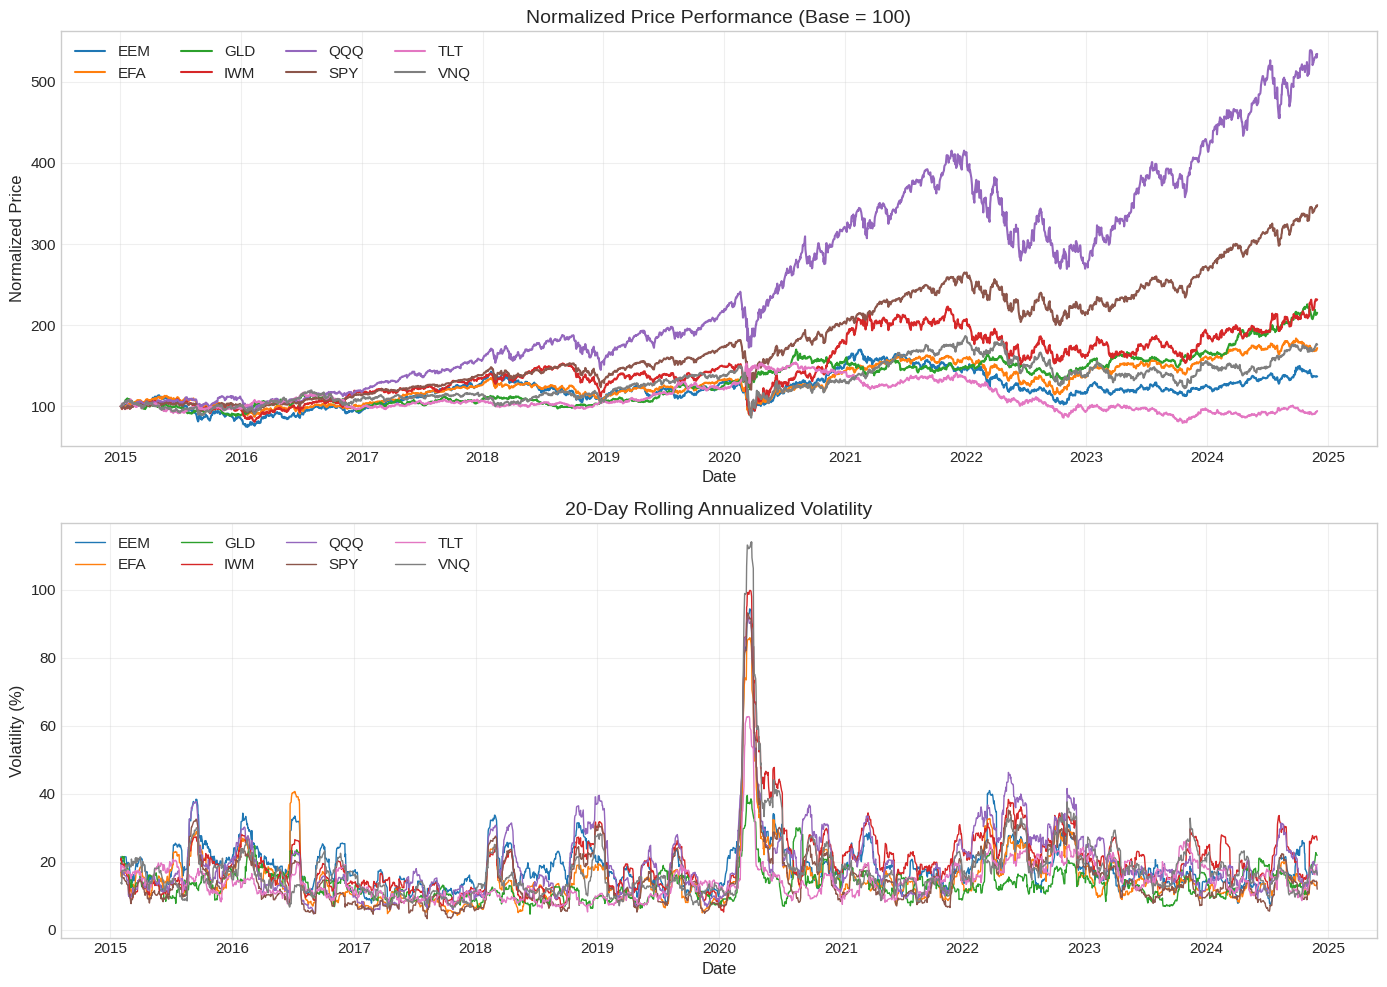


Price overview saved as 'price_data_overview.png'


In [4]:
# -----------------------------------------------------------------------------
# 1.1c Verify Data Quality
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("1.1c Data Quality Check")
print("-"*60)

print("\nPrice Statistics Summary:")
print(prices_df.describe().round(2))

print("\nMissing Values per Asset:")
print(prices_df.isnull().sum())

print("\nFirst 5 rows:")
print(prices_df.head())

print("\nLast 5 rows:")
print(prices_df.tail())

# Plot price series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Normalized prices (base 100)
normalized = (prices_df / prices_df.iloc[0]) * 100
ax1 = axes[0]
for col in normalized.columns:
    ax1.plot(normalized.index, normalized[col], label=col, linewidth=1.5)
ax1.set_title('Normalized Price Performance (Base = 100)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Price')
ax1.legend(loc='upper left', ncol=4)
ax1.grid(True, alpha=0.3)

# Rolling volatility
ax2 = axes[1]
for col in prices_df.columns:
    vol = prices_df[col].pct_change().rolling(20).std() * np.sqrt(252) * 100
    ax2.plot(vol.index, vol, label=col, linewidth=1)
ax2.set_title('20-Day Rolling Annualized Volatility')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volatility (%)')
ax2.legend(loc='upper left', ncol=4)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('price_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPrice overview saved as 'price_data_overview.png'")

In [5]:
# -----------------------------------------------------------------------------
# 1.2 Feature Engineering for Financial Analysis
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("1.2 Feature Engineering")
print("-"*60)

def calculate_technical_features(prices, window_short=5, window_medium=20, window_long=60):
    """
    Calculate technical indicators for financial analysis.

    Parameters:
    -----------
    prices : pd.DataFrame
        Price data for multiple assets
    window_short : int
        Short-term window (default: 5 days)
    window_medium : int
        Medium-term window (default: 20 days)
    window_long : int
        Long-term window (default: 60 days)

    Returns:
    --------
    pd.DataFrame
        DataFrame with technical features
    """
    features = pd.DataFrame(index=prices.index)

    for ticker in prices.columns:
        price = prices[ticker]

        # Returns at different horizons
        features[f'{ticker}_ret_1d'] = price.pct_change(1)
        features[f'{ticker}_ret_5d'] = price.pct_change(window_short)
        features[f'{ticker}_ret_20d'] = price.pct_change(window_medium)

        # Volatility measures
        features[f'{ticker}_vol_5d'] = price.pct_change().rolling(window_short).std()
        features[f'{ticker}_vol_20d'] = price.pct_change().rolling(window_medium).std()

        # Moving average ratios (momentum indicators)
        ma_short = price.rolling(window_short).mean()
        ma_medium = price.rolling(window_medium).mean()
        ma_long = price.rolling(window_long).mean()

        features[f'{ticker}_ma_ratio_short'] = price / ma_short - 1
        features[f'{ticker}_ma_ratio_medium'] = price / ma_medium - 1
        features[f'{ticker}_ma_ratio_long'] = price / ma_long - 1

        # Trend indicators
        features[f'{ticker}_trend'] = ma_short / ma_long - 1

        # RSI (Relative Strength Index)
        delta = price.diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / (loss + 1e-10)  # Avoid division by zero
        features[f'{ticker}_rsi'] = 100 - (100 / (1 + rs))

    return features

# Calculate features
print("\nCalculating technical features...")
features_df = calculate_technical_features(prices_df)

print(f"Feature matrix shape (before cleaning): {features_df.shape}")
print(f"Number of features per asset: {features_df.shape[1] // len(tickers)}")
print(f"Total features: {features_df.shape[1]}")


------------------------------------------------------------
1.2 Feature Engineering
------------------------------------------------------------

Calculating technical features...
Feature matrix shape (before cleaning): (2495, 80)
Number of features per asset: 10
Total features: 80


In [6]:
# -----------------------------------------------------------------------------
# 1.3 Create Target Variables for Classification
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("1.3 Creating Target Variables")
print("-"*60)

# Use SPY as the target asset
target_ticker = 'SPY'
print(f"Using {target_ticker} for target variable creation")

# Create a master DataFrame with features and targets
# This ensures proper alignment

master_df = features_df.copy()

# Target 1: Market direction (next day return)
# Shift by -1 to predict NEXT day's direction
spy_next_return = prices_df[target_ticker].pct_change().shift(-1)
master_df['target_direction'] = (spy_next_return > 0).astype(float)

# For Target 2: Market regime based on current volatility and trailing return
spy_vol_20d = prices_df[target_ticker].pct_change().rolling(20).std()
spy_ret_20d = prices_df[target_ticker].pct_change(20)

master_df['_vol'] = spy_vol_20d
master_df['_ret'] = spy_ret_20d

# Drop all NaN values - this ensures alignment
print(f"\nRows before dropping NaN: {len(master_df)}")
master_df = master_df.dropna()
print(f"Rows after dropping NaN: {len(master_df)}")

# Calculate regime classification
vol_median = master_df['_vol'].median()
print(f"Volatility median threshold: {vol_median:.6f}")

def classify_regime(row):
    """Classify market regime based on volatility and returns."""
    if row['_ret'] > 0 and row['_vol'] <= vol_median:
        return 0  # Low Vol Bull
    elif row['_ret'] > 0 and row['_vol'] > vol_median:
        return 1  # High Vol Bull
    elif row['_ret'] <= 0 and row['_vol'] <= vol_median:
        return 2  # Low Vol Bear
    else:
        return 3  # High Vol Bear

master_df['target_regime'] = master_df.apply(classify_regime, axis=1).astype(int)

# Remove helper columns
master_df = master_df.drop(columns=['_vol', '_ret'])

# Display target distribution
print("\n" + "="*50)
print("TARGET VARIABLE DISTRIBUTIONS")
print("="*50)

print("\nTarget 1: Market Direction (Binary)")
direction_dist = master_df['target_direction'].value_counts(normalize=True).round(3)
print(f"  Down (0): {direction_dist.get(0.0, 0):.1%}")
print(f"  Up (1): {direction_dist.get(1.0, 0):.1%}")

print("\nTarget 2: Market Regime (Multiclass)")
regime_labels = {0: 'Low Vol Bull', 1: 'High Vol Bull',
                 2: 'Low Vol Bear', 3: 'High Vol Bear'}
regime_counts = master_df['target_regime'].value_counts(normalize=True).sort_index()
for idx, pct in regime_counts.items():
    print(f"  {regime_labels[idx]}: {pct:.1%}")

print(f"\nFinal dataset shape: {master_df.shape}")
print(f"Date range: {master_df.index[0]} to {master_df.index[-1]}")


------------------------------------------------------------
1.3 Creating Target Variables
------------------------------------------------------------
Using SPY for target variable creation

Rows before dropping NaN: 2495
Rows after dropping NaN: 2436
Volatility median threshold: 0.007634

TARGET VARIABLE DISTRIBUTIONS

Target 1: Market Direction (Binary)
  Down (0): 45.2%
  Up (1): 54.8%

Target 2: Market Regime (Multiclass)
  Low Vol Bull: 43.1%
  High Vol Bull: 25.7%
  Low Vol Bear: 6.9%
  High Vol Bear: 24.3%

Final dataset shape: (2436, 82)
Date range: 2015-03-30 00:00:00 to 2024-11-29 00:00:00


In [7]:
# -----------------------------------------------------------------------------
# 1.4 Prepare Data for Modeling
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("1.4 Preparing Data for Modeling")
print("-"*60)

# Select feature columns (exclude targets)
feature_cols = [col for col in master_df.columns
                if not col.startswith('target')]

print(f"Number of features: {len(feature_cols)}")

# Extract arrays
X = master_df[feature_cols].values
y_direction = master_df['target_direction'].values.astype(int)
y_regime = master_df['target_regime'].values.astype(int)

# Time-series aware train/test split (80/20)
split_idx = int(len(X) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train_dir, y_test_dir = y_direction[:split_idx], y_direction[split_idx:]
y_train_reg, y_test_reg = y_regime[:split_idx], y_regime[split_idx:]

# Store dates for later analysis
train_dates = master_df.index[:split_idx]
test_dates = master_df.index[split_idx:]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*50)
print("DATA SPLIT SUMMARY")
print("="*50)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Train date range: {train_dates[0].strftime('%Y-%m-%d')} to {train_dates[-1].strftime('%Y-%m-%d')}")
print(f"Test date range: {test_dates[0].strftime('%Y-%m-%d')} to {test_dates[-1].strftime('%Y-%m-%d')}")

print("\nTraining set class distribution (Direction):")
print(f"  Down: {(y_train_dir == 0).sum()} ({(y_train_dir == 0).mean():.1%})")
print(f"  Up: {(y_train_dir == 1).sum()} ({(y_train_dir == 1).mean():.1%})")

print("\nTest set class distribution (Direction):")
print(f"  Down: {(y_test_dir == 0).sum()} ({(y_test_dir == 0).mean():.1%})")
print(f"  Up: {(y_test_dir == 1).sum()} ({(y_test_dir == 1).mean():.1%})")


------------------------------------------------------------
1.4 Preparing Data for Modeling
------------------------------------------------------------
Number of features: 80

DATA SPLIT SUMMARY
Training samples: 1948
Testing samples: 488
Number of features: 80
Train date range: 2015-03-30 to 2022-12-20
Test date range: 2022-12-21 to 2024-11-29

Training set class distribution (Direction):
  Down: 893 (45.8%)
  Up: 1055 (54.2%)

Test set class distribution (Direction):
  Down: 208 (42.6%)
  Up: 280 (57.4%)


In [8]:
# =============================================================================
# SECTION 2: LINEAR DISCRIMINANT ANALYSIS (LDA)
# =============================================================================

print("\n" + "="*80)
print("SECTION 2: LINEAR DISCRIMINANT ANALYSIS (LDA)")
print("="*80)

# -----------------------------------------------------------------------------
# 2.1 LDA for Binary Classification (Market Direction)
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("2.1 LDA for Binary Classification: Market Direction Prediction")
print("-"*60)

# Fit LDA with different shrinkage values
shrinkage_values = [None, 'auto', 0.0, 0.25, 0.5, 0.75, 1.0]
lda_results = []

for shrink in shrinkage_values:
    try:
        if shrink is None:
            lda = LinearDiscriminantAnalysis(solver='svd')
        else:
            lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrink)

        lda.fit(X_train_scaled, y_train_dir)

        train_acc = lda.score(X_train_scaled, y_train_dir)
        test_acc = lda.score(X_test_scaled, y_test_dir)

        # Cross-validation with time series split
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(lda, X_train_scaled, y_train_dir, cv=tscv)

        lda_results.append({
            'shrinkage': str(shrink),
            'train_accuracy': round(train_acc, 4),
            'test_accuracy': round(test_acc, 4),
            'cv_mean': round(cv_scores.mean(), 4),
            'cv_std': round(cv_scores.std(), 4)
        })
        print(f"  Shrinkage={shrink}: Train={train_acc:.4f}, Test={test_acc:.4f}, CV={cv_scores.mean():.4f}")
    except Exception as e:
        print(f"  Warning: shrinkage={shrink} failed - {e}")

lda_results_df = pd.DataFrame(lda_results)
print("\n" + "="*60)
print("LDA Performance with Different Shrinkage Values:")
print(lda_results_df.to_string(index=False))

# Select best model based on CV score
best_idx = lda_results_df['cv_mean'].idxmax()
best_shrinkage = lda_results_df.loc[best_idx, 'shrinkage']
print(f"\nBest shrinkage parameter: {best_shrinkage}")


SECTION 2: LINEAR DISCRIMINANT ANALYSIS (LDA)

------------------------------------------------------------
2.1 LDA for Binary Classification: Market Direction Prediction
------------------------------------------------------------
  Shrinkage=None: Train=0.5770, Test=0.5410, CV=0.5043
  Shrinkage=auto: Train=0.5647, Test=0.5410, CV=0.5099
  Shrinkage=0.0: Train=0.5765, Test=0.5410, CV=0.5043
  Shrinkage=0.25: Train=0.5575, Test=0.5492, CV=0.5062
  Shrinkage=0.5: Train=0.5529, Test=0.5574, CV=0.5031
  Shrinkage=0.75: Train=0.5513, Test=0.5553, CV=0.5068
  Shrinkage=1.0: Train=0.5257, Test=0.5287, CV=0.4907

LDA Performance with Different Shrinkage Values:
shrinkage  train_accuracy  test_accuracy  cv_mean  cv_std
     None          0.5770         0.5410   0.5043  0.0225
     auto          0.5647         0.5410   0.5099  0.0251
      0.0          0.5765         0.5410   0.5043  0.0225
     0.25          0.5575         0.5492   0.5062  0.0293
      0.5          0.5529         0.5574   0.

In [9]:
# -----------------------------------------------------------------------------
# 2.2 Train Final LDA Model for Binary Classification
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("2.2 Final LDA Model - Binary Classification")
print("-"*60)

# Train final model with best shrinkage
if best_shrinkage == 'None':
    lda_binary = LinearDiscriminantAnalysis(solver='svd')
elif best_shrinkage == 'auto':
    lda_binary = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
else:
    lda_binary = LinearDiscriminantAnalysis(solver='lsqr',
                                            shrinkage=float(best_shrinkage))

lda_binary.fit(X_train_scaled, y_train_dir)

# Predictions
y_pred_train_lda = lda_binary.predict(X_train_scaled)
y_pred_test = lda_binary.predict(X_test_scaled)
y_proba_test = lda_binary.predict_proba(X_test_scaled)[:, 1]

# Performance metrics
print("\nClassification Report (Test Set):")
print(classification_report(y_test_dir, y_pred_test,
                           target_names=['Down', 'Up']))

# Confusion Matrix
cm = confusion_matrix(y_test_dir, y_pred_test)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC
roc_auc = roc_auc_score(y_test_dir, y_proba_test)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Additional metrics
print(f"\nAdditional Metrics:")
print(f"  Training Accuracy: {lda_binary.score(X_train_scaled, y_train_dir):.4f}")
print(f"  Test Accuracy: {lda_binary.score(X_test_scaled, y_test_dir):.4f}")


------------------------------------------------------------
2.2 Final LDA Model - Binary Classification
------------------------------------------------------------

Classification Report (Test Set):
              precision    recall  f1-score   support

        Down       0.45      0.31      0.37       208
          Up       0.58      0.71      0.64       280

    accuracy                           0.54       488
   macro avg       0.51      0.51      0.50       488
weighted avg       0.52      0.54      0.52       488


Confusion Matrix:
[[ 65 143]
 [ 81 199]]

ROC-AUC Score: 0.5181

Additional Metrics:
  Training Accuracy: 0.5647
  Test Accuracy: 0.5410


In [10]:
# -----------------------------------------------------------------------------
# 2.3 LDA Coefficient Analysis and Feature Importance
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("2.3 LDA Feature Importance Analysis")
print("-"*60)

# Get LDA coefficients
lda_coefs = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lda_binary.coef_[0],
    'abs_coefficient': np.abs(lda_binary.coef_[0])
})
lda_coefs = lda_coefs.sort_values('abs_coefficient', ascending=False)

print("\nTop 15 Most Important Features (by absolute coefficient):")
print(lda_coefs.head(15).to_string(index=False))

# Store for visualization
top_features_lda = lda_coefs.head(20)


------------------------------------------------------------
2.3 LDA Feature Importance Analysis
------------------------------------------------------------

Top 15 Most Important Features (by absolute coefficient):
            feature  coefficient  abs_coefficient
        IWM_vol_20d     0.216274         0.216274
        EFA_vol_20d    -0.175170         0.175170
  IWM_ma_ratio_long     0.154845         0.154845
 SPY_ma_ratio_short    -0.153320         0.153320
         EFA_ret_1d    -0.150567         0.150567
        SPY_vol_20d    -0.145404         0.145404
          IWM_trend     0.144840         0.144840
IWM_ma_ratio_medium    -0.143361         0.143361
QQQ_ma_ratio_medium     0.132682         0.132682
         TLT_ret_5d     0.126908         0.126908
         TLT_vol_5d    -0.122142         0.122142
 QQQ_ma_ratio_short     0.121139         0.121139
         SPY_ret_1d    -0.119866         0.119866
 EFA_ma_ratio_short     0.118861         0.118861
        QQQ_ret_20d    -0.117737

In [11]:
# -----------------------------------------------------------------------------
# 2.4 LDA for Multiclass Classification (Market Regime)
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("2.4 LDA for Multiclass Classification: Market Regime")
print("-"*60)

# Train LDA for regime classification
lda_multiclass = LinearDiscriminantAnalysis(solver='svd') # Changed solver from 'lsqr' to 'svd'
lda_multiclass.fit(X_train_scaled, y_train_reg)

# Predictions
y_pred_regime = lda_multiclass.predict(X_test_scaled)
y_proba_regime = lda_multiclass.predict_proba(X_test_scaled)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_reg, y_pred_regime,
                           target_names=['Low Vol Bull', 'High Vol Bull',
                                        'Low Vol Bear', 'High Vol Bear']))

# Multiclass accuracy
regime_accuracy = accuracy_score(y_test_reg, y_pred_regime)
print(f"\nOverall Accuracy: {regime_accuracy:.4f}")

# Explained variance ratio (dimensionality reduction aspect)
print(f"\nExplained Variance Ratio by Discriminant Axes:")
for i, var in enumerate(lda_multiclass.explained_variance_ratio_):
    print(f"  LD{i+1}: {var:.4f} ({var*100:.2f} %)")
print(f"  Cumulative: {sum(lda_multiclass.explained_variance_ratio_)*100:.2f}%")


------------------------------------------------------------
2.4 LDA for Multiclass Classification: Market Regime
------------------------------------------------------------

Classification Report (Test Set):
               precision    recall  f1-score   support

 Low Vol Bull       0.65      0.86      0.74       214
High Vol Bull       0.76      0.43      0.55       147
 Low Vol Bear       0.28      0.66      0.39        38
High Vol Bear       0.88      0.34      0.49        89

     accuracy                           0.62       488
    macro avg       0.64      0.57      0.54       488
 weighted avg       0.70      0.62      0.61       488


Overall Accuracy: 0.6168

Explained Variance Ratio by Discriminant Axes:
  LD1: 0.6648 (66.48 %)
  LD2: 0.2746 (27.46 %)
  LD3: 0.0606 (6.06 %)
  Cumulative: 100.00%


In [12]:
# -----------------------------------------------------------------------------
# 2.5 LDA Visualizations
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("2.5 LDA Visualizations")
print("-"*60)

print("\nLDA visualizations have been moved to individual cells with descriptions.")


------------------------------------------------------------
2.5 LDA Visualizations
------------------------------------------------------------

LDA visualizations have been moved to individual cells with descriptions.


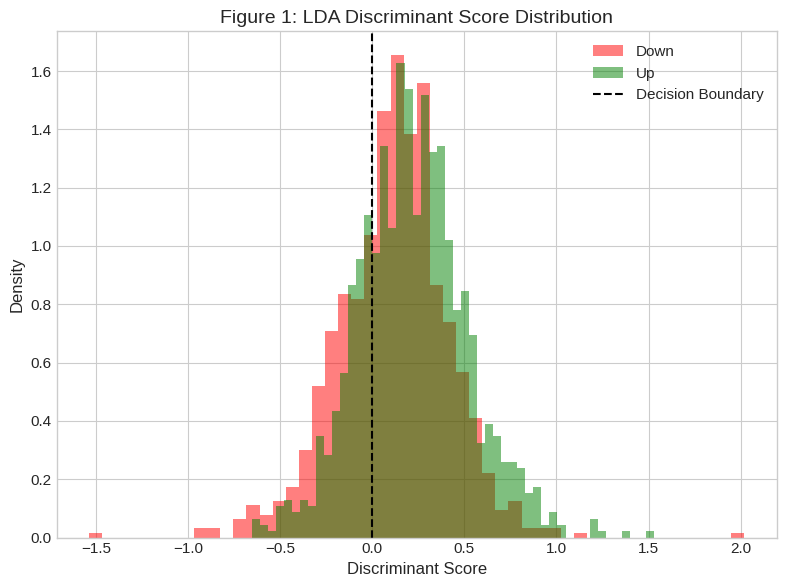


LDA Discriminant Score Distribution saved as 'lda_discriminant_score_distribution.png'


In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
lda_scores_train = lda_binary.decision_function(X_train_scaled)
for label, name, color in [(0, 'Down', 'red'), (1, 'Up', 'green')]:
    mask = y_train_dir == label
    ax.hist(lda_scores_train[mask], bins=50, alpha=0.5, label=name,
             color=color, density=True)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Decision Boundary')
ax.set_xlabel('Discriminant Score')
ax.set_ylabel('Density')
ax.set_title('Figure 1: LDA Discriminant Score Distribution')
ax.legend()
plt.tight_layout()
plt.savefig('lda_discriminant_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLDA Discriminant Score Distribution saved as 'lda_discriminant_score_distribution.png'")

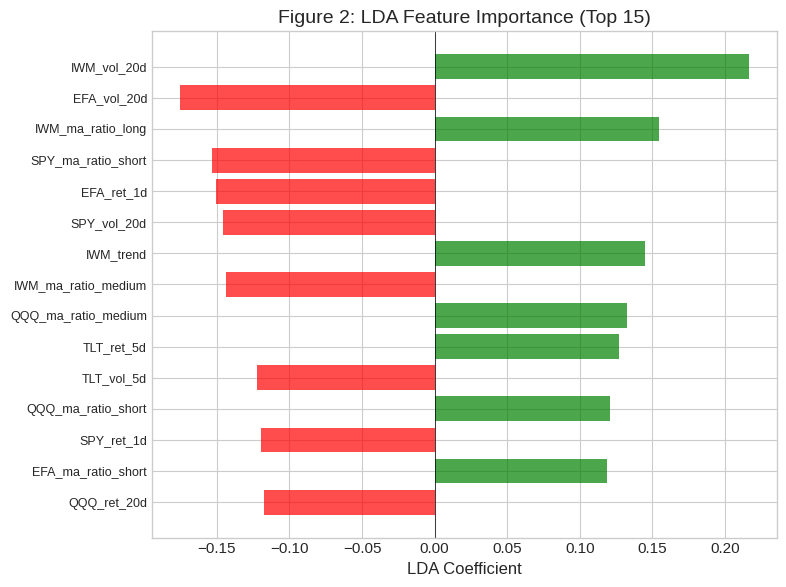


LDA Feature Importance saved as 'lda_feature_importance.png'


In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
top_15 = top_features_lda.head(15)
colors = ['green' if c > 0 else 'red' for c in top_15['coefficient']]
ax.barh(range(15), top_15['coefficient'].values, color=colors, alpha=0.7)
ax.set_yticks(range(15))
ax.set_yticklabels(top_15['feature'].values, fontsize=9)
ax.set_xlabel('LDA Coefficient')
ax.set_title('Figure 2: LDA Feature Importance (Top 15)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('lda_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLDA Feature Importance saved as 'lda_feature_importance.png'")

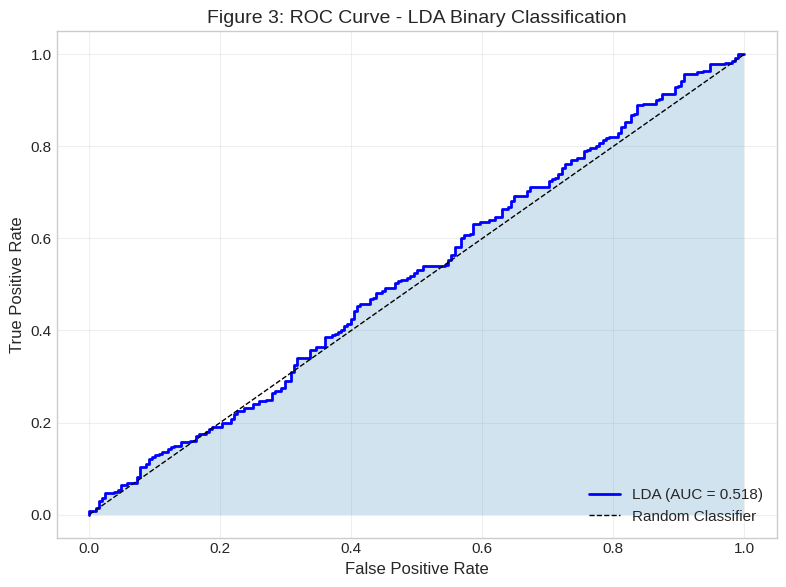


LDA ROC Curve saved as 'lda_roc_curve.png'


In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test_dir, y_proba_test)
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'LDA (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Figure 3: ROC Curve - LDA Binary Classification')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lda_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLDA ROC Curve saved as 'lda_roc_curve.png'")

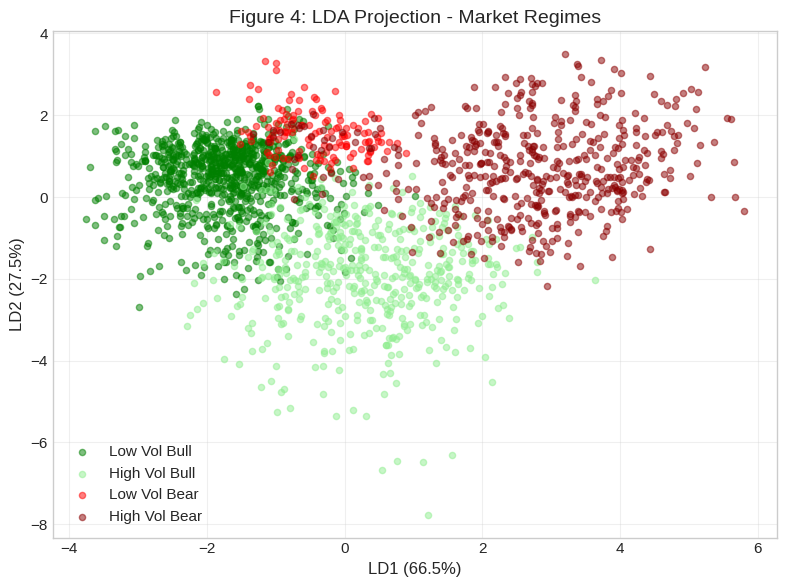


LDA Projection - Market Regimes saved as 'lda_projection_market_regimes.png'


In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

X_lda = lda_multiclass.transform(X_train_scaled)

regime_colors = {0: 'green', 1: 'lightgreen', 2: 'red', 3: 'darkred'}
regime_names = {0: 'Low Vol Bull', 1: 'High Vol Bull',
                2: 'Low Vol Bear', 3: 'High Vol Bear'}

for regime in range(4):
    mask = y_train_reg == regime
    if X_lda.shape[1] >= 2:
        ax.scatter(X_lda[mask, 0], X_lda[mask, 1],
                   c=regime_colors[regime], label=regime_names[regime],
                   alpha=0.5, s=20)

if X_lda.shape[1] >= 2:
    ax.set_xlabel(f'LD1 ({lda_multiclass.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'LD2 ({lda_multiclass.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('Figure 4: LDA Projection - Market Regimes')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lda_projection_market_regimes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLDA Projection - Market Regimes saved as 'lda_projection_market_regimes.png'")


------------------------------------------------------------
2.6 LDA Dimensionality Reduction Visualization
------------------------------------------------------------


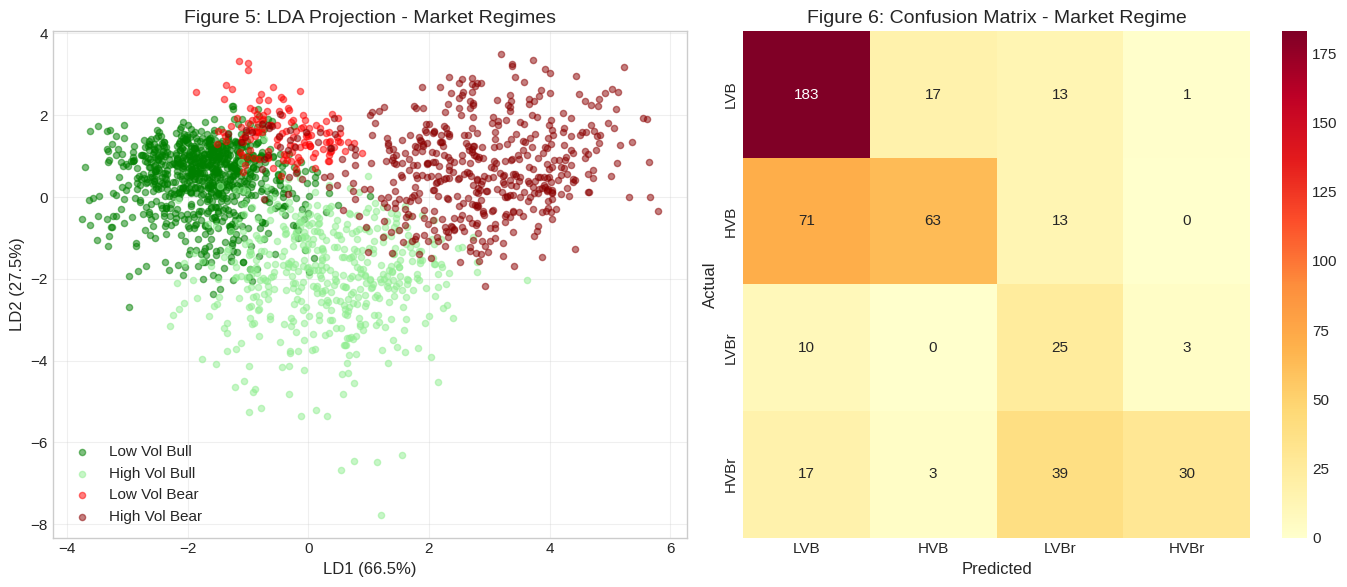


LDA projection visualization saved as 'lda_projection.png'


In [17]:
# -----------------------------------------------------------------------------
# 2.6 LDA Dimensionality Reduction Visualization (Multiclass)
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("2.6 LDA Dimensionality Reduction Visualization")
print("-"*60)

# Transform data to LDA space
X_lda = lda_multiclass.transform(X_train_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 2D projection (LD1 vs LD2)
ax1 = axes[0]
regime_colors = {0: 'green', 1: 'lightgreen', 2: 'red', 3: 'darkred'}
regime_names = {0: 'Low Vol Bull', 1: 'High Vol Bull',
                2: 'Low Vol Bear', 3: 'High Vol Bear'}

for regime in range(4):
    mask = y_train_reg == regime
    if X_lda.shape[1] >= 2:
        ax1.scatter(X_lda[mask, 0], X_lda[mask, 1],
                   c=regime_colors[regime], label=regime_names[regime],
                   alpha=0.5, s=20)

if X_lda.shape[1] >= 2:
    ax1.set_xlabel(f'LD1 ({lda_multiclass.explained_variance_ratio_[0]*100:.1f}%)')
    ax1.set_ylabel(f'LD2 ({lda_multiclass.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('Figure 5: LDA Projection - Market Regimes')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Confusion Matrix for Multiclass
ax2 = axes[1]
cm_multi = confusion_matrix(y_test_reg, y_pred_regime)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='YlOrRd', ax=ax2,
            xticklabels=['LVB', 'HVB', 'LVBr', 'HVBr'],
            yticklabels=['LVB', 'HVB', 'LVBr', 'HVBr'])
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Figure 6: Confusion Matrix - Market Regime')

plt.tight_layout()
plt.savefig('lda_projection.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLDA projection visualization saved as 'lda_projection.png'")

In [18]:
# =============================================================================
# SECTION 3: SUPPORT VECTOR MACHINES (SVM)
# =============================================================================

print("\n" + "="*80)
print("SECTION 3: SUPPORT VECTOR MACHINES (SVM)")
print("="*80)

# -----------------------------------------------------------------------------
# 3.1 SVM for Binary Classification with Different Kernels
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("3.1 SVM Kernel Comparison")
print("-"*60)

# Compare different kernels
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
svm_kernel_results = []

for kernel in kernels:
    print(f"\nTraining SVM with {kernel} kernel...")

    if kernel == 'linear':
        svm = SVC(kernel=kernel, C=1.0, random_state=42)
    elif kernel == 'poly':
        svm = SVC(kernel=kernel, C=1.0, degree=3, random_state=42)
    else:
        svm = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)

    svm.fit(X_train_scaled, y_train_dir)

    train_acc = svm.score(X_train_scaled, y_train_dir)
    test_acc = svm.score(X_test_scaled, y_test_dir)

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(svm, X_train_scaled, y_train_dir, cv=tscv)

    svm_kernel_results.append({
        'kernel': kernel,
        'train_accuracy': round(train_acc, 4),
        'test_accuracy': round(test_acc, 4),
        'cv_mean': round(cv_scores.mean(), 4),
        'cv_std': round(cv_scores.std(), 4),
        'n_support_vectors': sum(svm.n_support_)
    })
    print(f"  Train={train_acc:.4f}, Test={test_acc:.4f}, CV={cv_scores.mean():.4f}, SVs={sum(svm.n_support_)}")

svm_kernel_df = pd.DataFrame(svm_kernel_results)
print("\n" + "="*60)
print("SVM Kernel Comparison Results:")
print(svm_kernel_df.to_string(index=False))


SECTION 3: SUPPORT VECTOR MACHINES (SVM)

------------------------------------------------------------
3.1 SVM Kernel Comparison
------------------------------------------------------------

Training SVM with linear kernel...
  Train=0.5832, Test=0.5451, CV=0.5043, SVs=1776

Training SVM with rbf kernel...
  Train=0.6663, Test=0.6004, CV=0.5216, SVs=1850

Training SVM with poly kernel...
  Train=0.6304, Test=0.5799, CV=0.5123, SVs=1813

Training SVM with sigmoid kernel...
  Train=0.4933, Test=0.5246, CV=0.4914, SVs=1201

SVM Kernel Comparison Results:
 kernel  train_accuracy  test_accuracy  cv_mean  cv_std  n_support_vectors
 linear          0.5832         0.5451   0.5043  0.0383               1776
    rbf          0.6663         0.6004   0.5216  0.0243               1850
   poly          0.6304         0.5799   0.5123  0.0551               1813
sigmoid          0.4933         0.5246   0.4914  0.0396               1201


In [19]:
# -----------------------------------------------------------------------------
# 3.2 SVM Hyperparameter Tuning with Grid Search
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("3.2 SVM Hyperparameter Tuning (Grid Search)")
print("-"*60)

# Define parameter grid for RBF kernel
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print("\nPerforming Grid Search (this may take a few minutes)...")
svm_rbf = SVC(kernel='rbf', random_state=42)
grid_search = GridSearchCV(svm_rbf, param_grid, cv=tscv,
                           scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train_dir)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

# Store results for visualization
cv_results = pd.DataFrame(grid_search.cv_results_)


------------------------------------------------------------
3.2 SVM Hyperparameter Tuning (Grid Search)
------------------------------------------------------------

Performing Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Parameters: {'C': 0.01, 'gamma': 'scale'}
Best CV Score: 0.5469


In [20]:
# -----------------------------------------------------------------------------
# 3.3 Train Final SVM Model with Best Parameters
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("3.3 Final SVM Model Training")
print("-"*60)

# Train with best parameters and enable probability estimates
best_svm = SVC(**grid_search.best_params_, kernel='rbf',
               probability=True, random_state=42)
best_svm.fit(X_train_scaled, y_train_dir)

# Predictions
y_pred_svm = best_svm.predict(X_test_scaled)
y_proba_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test_dir, y_pred_svm,
                           target_names=['Down', 'Up']))

# Confusion Matrix
cm_svm = confusion_matrix(y_test_dir, y_pred_svm)
print("\nConfusion Matrix:")
print(cm_svm)

# ROC-AUC
roc_auc_svm = roc_auc_score(y_test_dir, y_proba_svm)
print(f"\nROC-AUC Score: {roc_auc_svm:.4f}")

# Support vector statistics
print(f"\nSupport Vector Statistics:")
print(f"  Total support vectors: {sum(best_svm.n_support_)}")
print(f"  Support vectors per class: {best_svm.n_support_}")
print(f"  Percentage of training data: {sum(best_svm.n_support_) / len(X_train_scaled) * 100:.2f}%")


------------------------------------------------------------
3.3 Final SVM Model Training
------------------------------------------------------------

Classification Report (Test Set):
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00       208
          Up       0.57      1.00      0.73       280

    accuracy                           0.57       488
   macro avg       0.29      0.50      0.36       488
weighted avg       0.33      0.57      0.42       488


Confusion Matrix:
[[  0 208]
 [  0 280]]

ROC-AUC Score: 0.4411

Support Vector Statistics:
  Total support vectors: 1849
  Support vectors per class: [893 956]
  Percentage of training data: 94.92%


In [21]:
# -----------------------------------------------------------------------------
# 3.4 Effect of Regularization Parameter C
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("3.4 Effect of Regularization Parameter C")
print("-"*60)

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
c_results = []

for C in C_values:
    svm_c = SVC(kernel='rbf', C=C, gamma='scale', random_state=42)
    svm_c.fit(X_train_scaled, y_train_dir)

    c_results.append({
        'C': C,
        'train_accuracy': round(svm_c.score(X_train_scaled, y_train_dir), 4),
        'test_accuracy': round(svm_c.score(X_test_scaled, y_test_dir), 4),
        'n_support_vectors': sum(svm_c.n_support_)
    })

c_results_df = pd.DataFrame(c_results)
print("\nEffect of C on SVM Performance:")
print(c_results_df.to_string(index=False))


------------------------------------------------------------
3.4 Effect of Regularization Parameter C
------------------------------------------------------------

Effect of C on SVM Performance:
       C  train_accuracy  test_accuracy  n_support_vectors
   0.001          0.5416         0.5738               1793
   0.010          0.5416         0.5738               1849
   0.100          0.5416         0.5738               1850
   1.000          0.6663         0.6004               1850
  10.000          0.8799         0.5082               1746
 100.000          0.9938         0.5184               1538
1000.000          1.0000         0.5205               1486


In [22]:
# -----------------------------------------------------------------------------
# 3.5 SVM for Multiclass Classification (Market Regime)
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("3.5 SVM Multiclass Classification: Market Regime")
print("-"*60)

# Train multiclass SVM
svm_multiclass = SVC(kernel='rbf', C=10, gamma='scale',
                     probability=True, random_state=42)
svm_multiclass.fit(X_train_scaled, y_train_reg)

# Predictions
y_pred_svm_reg = svm_multiclass.predict(X_test_scaled)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_reg, y_pred_svm_reg,
                           target_names=['Low Vol Bull', 'High Vol Bull',
                                        'Low Vol Bear', 'High Vol Bear']))

# Overall accuracy
svm_reg_accuracy = accuracy_score(y_test_reg, y_pred_svm_reg)
print(f"\nOverall Accuracy: {svm_reg_accuracy:.4f}")


------------------------------------------------------------
3.5 SVM Multiclass Classification: Market Regime
------------------------------------------------------------

Classification Report (Test Set):
               precision    recall  f1-score   support

 Low Vol Bull       0.82      0.80      0.81       214
High Vol Bull       0.67      0.78      0.72       147
 Low Vol Bear       0.50      0.32      0.39        38
High Vol Bear       0.68      0.65      0.67        89

     accuracy                           0.73       488
    macro avg       0.67      0.64      0.65       488
 weighted avg       0.72      0.73      0.72       488


Overall Accuracy: 0.7275


In [23]:
# -----------------------------------------------------------------------------
# 3.6 SVM Visualizations
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("3.6 SVM Visualizations")
print("-"*60)

print("\nSVM visualizations have been moved to individual cells with descriptions.")


------------------------------------------------------------
3.6 SVM Visualizations
------------------------------------------------------------

SVM visualizations have been moved to individual cells with descriptions.


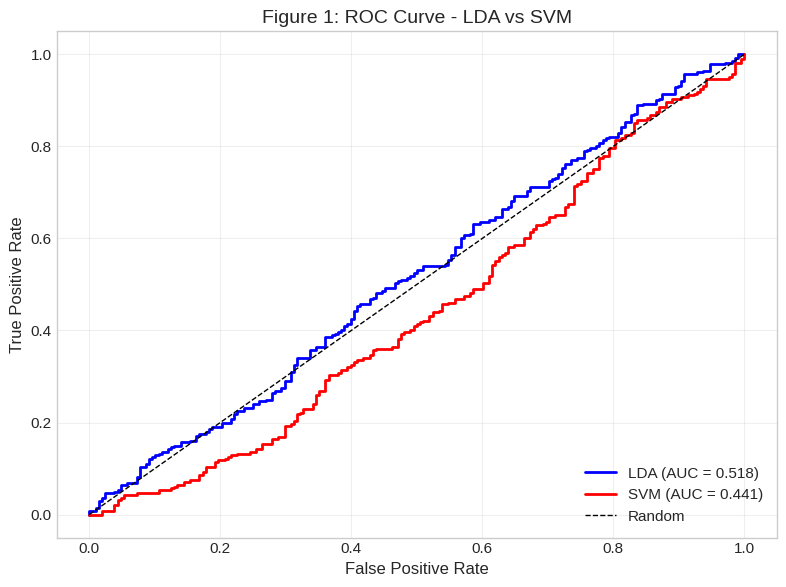


ROC Curve comparison (LDA vs SVM) saved as 'svm_lda_roc_comparison.png'


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(figsize=(8, 6))

fpr_lda, tpr_lda, _ = roc_curve(y_test_dir, y_proba_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test_dir, y_proba_svm)

ax.plot(fpr_lda, tpr_lda, 'b-', linewidth=2, label=f'LDA (AUC = {roc_auc:.3f})')
ax.plot(fpr_svm, tpr_svm, 'r-', linewidth=2, label=f'SVM (AUC = {roc_auc_svm:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Figure 1: ROC Curve - LDA vs SVM')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svm_lda_roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nROC Curve comparison (LDA vs SVM) saved as 'svm_lda_roc_comparison.png'")

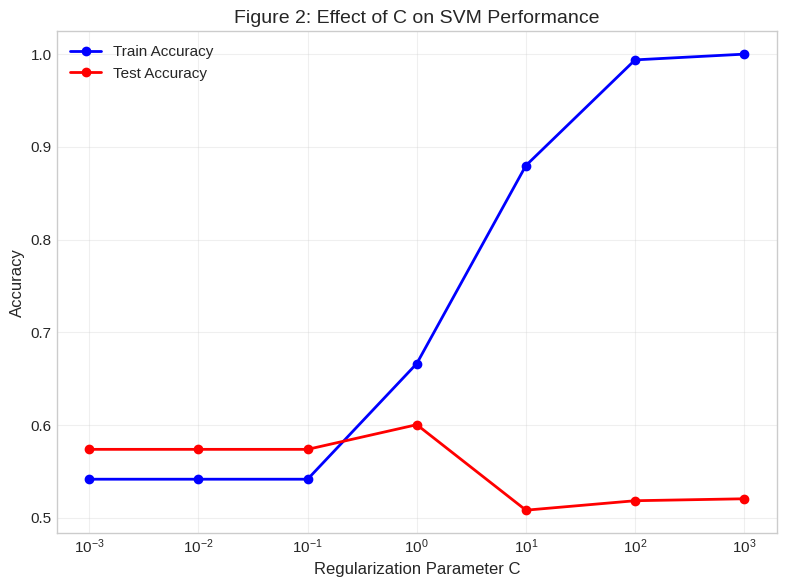


Effect of C on SVM Performance saved as 'svm_effect_of_c.png'


In [25]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(8, 6))

ax.semilogx(c_results_df['C'], c_results_df['train_accuracy'],
             'b-o', label='Train Accuracy', linewidth=2)
ax.semilogx(c_results_df['C'], c_results_df['test_accuracy'],
             'r-o', label='Test Accuracy', linewidth=2)
ax.set_xlabel('Regularization Parameter C')
ax.set_ylabel('Accuracy')
ax.set_title('Figure 2: Effect of C on SVM Performance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svm_effect_of_c.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEffect of C on SVM Performance saved as 'svm_effect_of_c.png'")

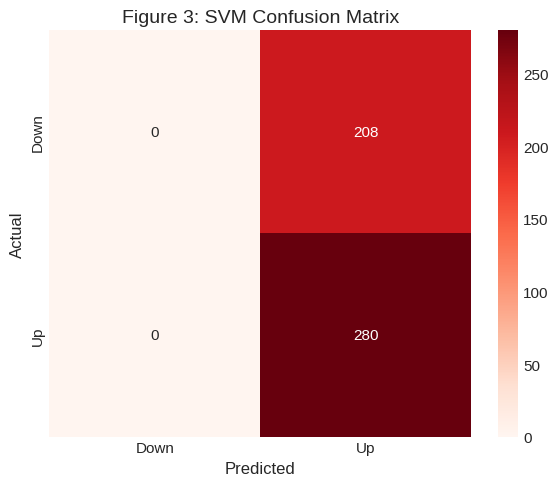


SVM Confusion Matrix saved as 'svm_confusion_matrix.png'


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(6, 5))

cm_svm = confusion_matrix(y_test_dir, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', ax=ax,
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Figure 3: SVM Confusion Matrix')

plt.tight_layout()
plt.savefig('svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSVM Confusion Matrix saved as 'svm_confusion_matrix.png'")

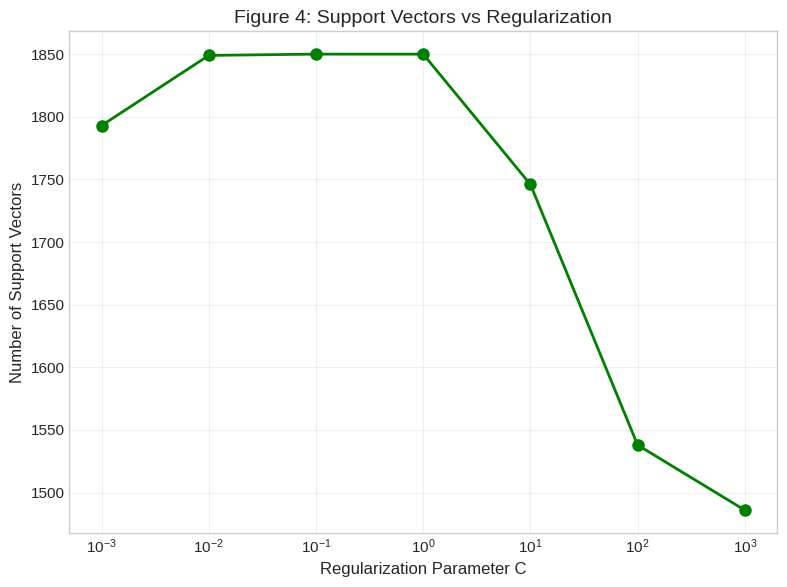


Support Vectors vs Regularization saved as 'svm_support_vectors_vs_c.png'


In [27]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(8, 6))

ax.semilogx(c_results_df['C'], c_results_df['n_support_vectors'],
             'g-o', linewidth=2, markersize=8)
ax.set_xlabel('Regularization Parameter C')
ax.set_ylabel('Number of Support Vectors')
ax.set_title('Figure 4: Support Vectors vs Regularization')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svm_support_vectors_vs_c.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSupport Vectors vs Regularization saved as 'svm_support_vectors_vs_c.png'")


------------------------------------------------------------
3.7 SVM Decision Boundary Visualization
------------------------------------------------------------
PCA explained variance: [0.33438437 0.15078321]
Total variance explained: 48.5%


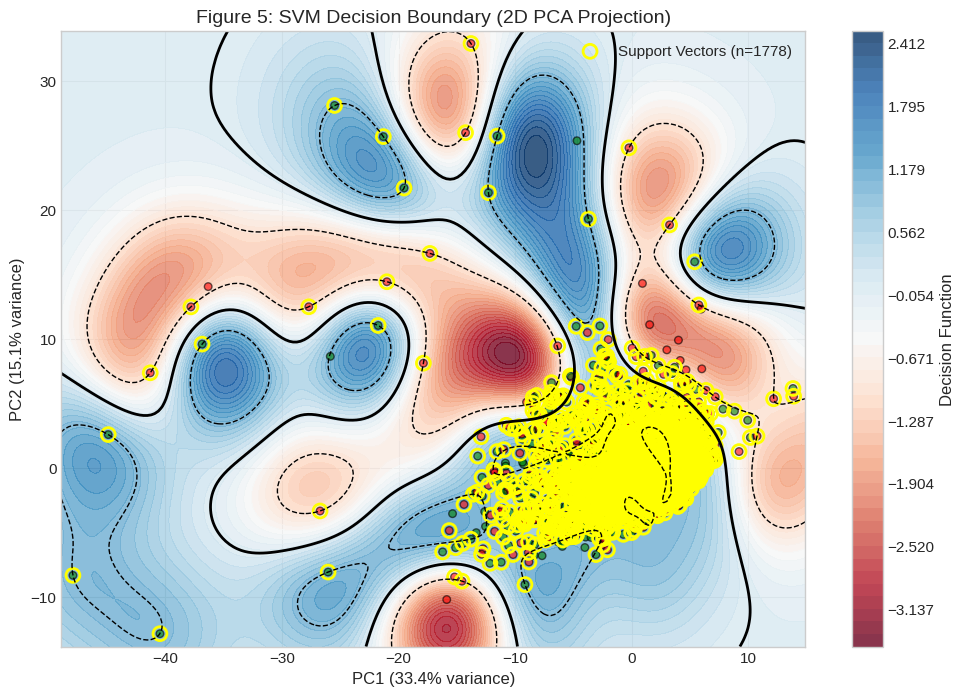


SVM decision boundary visualization saved as 'svm_decision_boundary.png'


In [28]:
# -----------------------------------------------------------------------------
# 3.7 SVM Decision Boundary Visualization (2D PCA Projection)
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("3.7 SVM Decision Boundary Visualization")
print("-"*60)

# Reduce to 2D using PCA for visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_scaled)
X_test_2d = pca_2d.transform(X_test_scaled)

print(f"PCA explained variance: {pca_2d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_2d.explained_variance_ratio_)*100:.1f}%")

# Train SVM on 2D data
svm_2d = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_2d.fit(X_train_2d, y_train_dir)

# Create mesh grid for decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = svm_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot decision boundary and margins
contour = ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50),
                      cmap='RdBu', alpha=0.8)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
ax.contour(xx, yy, Z, levels=[-1, 1], linewidths=1, colors='black',
           linestyles='dashed')

# Plot training points
colors_train = ['red' if y == 0 else 'green' for y in y_train_dir]
ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1],
           c=colors_train, edgecolors='black', s=30, alpha=0.6)

# Highlight support vectors
ax.scatter(X_train_2d[svm_2d.support_, 0],
           X_train_2d[svm_2d.support_, 1],
           s=100, facecolors='none', edgecolors='yellow',
           linewidths=2, label=f'Support Vectors (n={len(svm_2d.support_)})')

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title('Figure 5: SVM Decision Boundary (2D PCA Projection)')
ax.legend(loc='upper right')

plt.colorbar(contour, ax=ax, label='Decision Function')
plt.savefig('svm_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSVM decision boundary visualization saved as 'svm_decision_boundary.png'")

In [29]:
# =============================================================================
# SECTION 4: NEURAL NETWORKS
# =============================================================================

print("\n" + "="*80)
print("SECTION 4: NEURAL NETWORKS")
print("="*80)

# -----------------------------------------------------------------------------
# 4.1 Neural Network Architecture Comparison
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("4.1 Neural Network Architecture Comparison")
print("-"*60)

# Test different architectures
architectures = [
    ('Shallow (32)', (32,)),
    ('Shallow (64)', (64,)),
    ('Medium (64-32)', (64, 32)),
    ('Medium (128-64)', (128, 64)),
    ('Deep (128-64-32)', (128, 64, 32)),
    ('Deep (256-128-64)', (256, 128, 64)),
    ('Very Deep (256-128-64-32)', (256, 128, 64, 32))
]

nn_arch_results = []

for name, hidden_layers in architectures:
    print(f"\nTraining {name}...")

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation='relu',
        solver='adam',
        alpha=0.001,  # L2 regularization
        batch_size=64,
        learning_rate='adaptive',
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42,
        verbose=False
    )

    mlp.fit(X_train_scaled, y_train_dir)

    train_acc = mlp.score(X_train_scaled, y_train_dir)
    test_acc = mlp.score(X_test_scaled, y_test_dir)

    nn_arch_results.append({
        'architecture': name,
        'hidden_layers': str(hidden_layers),
        'train_accuracy': round(train_acc, 4),
        'test_accuracy': round(test_acc, 4),
        'n_iterations': mlp.n_iter_,
        'final_loss': round(mlp.loss_, 6)
    })
    print(f"  Train={train_acc:.4f}, Test={test_acc:.4f}, Iterations={mlp.n_iter_}")

nn_arch_df = pd.DataFrame(nn_arch_results)
print("\n" + "="*60)
print("Neural Network Architecture Comparison:")
print(nn_arch_df.to_string(index=False))


SECTION 4: NEURAL NETWORKS

------------------------------------------------------------
4.1 Neural Network Architecture Comparison
------------------------------------------------------------

Training Shallow (32)...
  Train=0.5056, Test=0.4775, Iterations=12

Training Shallow (64)...
  Train=0.5755, Test=0.5205, Iterations=14

Training Medium (64-32)...
  Train=0.6776, Test=0.5102, Iterations=22

Training Medium (128-64)...
  Train=0.7644, Test=0.5492, Iterations=24

Training Deep (128-64-32)...
  Train=0.8008, Test=0.5205, Iterations=24

Training Deep (256-128-64)...
  Train=0.5657, Test=0.5861, Iterations=12

Training Very Deep (256-128-64-32)...
  Train=0.7941, Test=0.4980, Iterations=20

Neural Network Architecture Comparison:
             architecture      hidden_layers  train_accuracy  test_accuracy  n_iterations  final_loss
             Shallow (32)              (32,)          0.5056         0.4775            12    0.652858
             Shallow (64)              (64,)       

In [30]:
# -----------------------------------------------------------------------------
# 4.2 Neural Network Hyperparameter Tuning
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("4.2 Neural Network Hyperparameter Tuning")
print("-"*60)

# Parameter grid for random search
param_distributions = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32), (64, 32, 16)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.0001],
    'batch_size': [32, 64, 128]
}

print("\nPerforming Random Search for Neural Network...")
mlp_base = MLPClassifier(
    solver='adam',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=False
)

tscv = TimeSeriesSplit(n_splits=5)
random_search_nn = RandomizedSearchCV(
    mlp_base,
    param_distributions,
    n_iter=20,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_nn.fit(X_train_scaled, y_train_dir)

print(f"\nBest Parameters: {random_search_nn.best_params_}")
print(f"Best CV Score: {random_search_nn.best_score_:.4f}")


------------------------------------------------------------
4.2 Neural Network Hyperparameter Tuning
------------------------------------------------------------

Performing Random Search for Neural Network...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters: {'learning_rate_init': 0.0001, 'hidden_layer_sizes': (128, 64), 'batch_size': 32, 'alpha': 0.01, 'activation': 'relu'}
Best CV Score: 0.5420


In [31]:
# -----------------------------------------------------------------------------
# 4.3 Train Final Neural Network Model
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("4.3 Final Neural Network Model")
print("-"*60)

# Train with best parameters
best_nn = MLPClassifier(
    **random_search_nn.best_params_,
    solver='adam',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=False
)

best_nn.fit(X_train_scaled, y_train_dir)

# Predictions
y_pred_nn = best_nn.predict(X_test_scaled)
y_proba_nn = best_nn.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test_dir, y_pred_nn,
                           target_names=['Down', 'Up']))

# Confusion Matrix
cm_nn = confusion_matrix(y_test_dir, y_pred_nn)
print("\nConfusion Matrix:")
print(cm_nn)

# ROC-AUC
roc_auc_nn = roc_auc_score(y_test_dir, y_proba_nn)
print(f"\nROC-AUC Score: {roc_auc_nn:.4f}")

# Network statistics
print(f"\nNetwork Statistics:")
print(f"  Hidden Layer Sizes: {best_nn.hidden_layer_sizes}")
print(f"  Number of Iterations: {best_nn.n_iter_}")
print(f"  Final Loss: {best_nn.loss_:.6f}")
print(f"  Number of layers: {best_nn.n_layers_}")
print(f"  Output activation: {best_nn.out_activation_}")


------------------------------------------------------------
4.3 Final Neural Network Model
------------------------------------------------------------

Classification Report (Test Set):
              precision    recall  f1-score   support

        Down       0.39      0.14      0.21       208
          Up       0.57      0.84      0.68       280

    accuracy                           0.54       488
   macro avg       0.48      0.49      0.44       488
weighted avg       0.49      0.54      0.48       488


Confusion Matrix:
[[ 30 178]
 [ 46 234]]

ROC-AUC Score: 0.4844

Network Statistics:
  Hidden Layer Sizes: (128, 64)
  Number of Iterations: 12
  Final Loss: 0.686455
  Number of layers: 4
  Output activation: logistic


In [32]:
# -----------------------------------------------------------------------------
# 4.4 Analysis of Regularization Effect
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("4.4 Effect of Regularization (Alpha)")
print("-"*60)

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
alpha_results = []

for alpha in alpha_values:
    mlp_alpha = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=alpha,
        batch_size=64,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42,
        verbose=False
    )

    mlp_alpha.fit(X_train_scaled, y_train_dir)

    alpha_results.append({
        'alpha': alpha,
        'train_accuracy': round(mlp_alpha.score(X_train_scaled, y_train_dir), 4),
        'test_accuracy': round(mlp_alpha.score(X_test_scaled, y_test_dir), 4),
        'n_iterations': mlp_alpha.n_iter_,
        'final_loss': round(mlp_alpha.loss_, 6)
    })

alpha_results_df = pd.DataFrame(alpha_results)
print("\nEffect of Alpha (L2 Regularization) on Neural Network:")
print(alpha_results_df.to_string(index=False))


------------------------------------------------------------
4.4 Effect of Regularization (Alpha)
------------------------------------------------------------

Effect of Alpha (L2 Regularization) on Neural Network:
  alpha  train_accuracy  test_accuracy  n_iterations  final_loss
0.00001          0.7320         0.5451            20    0.318233
0.00010          0.9163         0.5225            33    0.084754
0.00100          0.8008         0.5205            24    0.238061
0.01000          0.6042         0.5410            13    0.526793
0.10000          0.6052         0.5307            13    0.682741
1.00000          0.5780         0.5881            15    0.712796


In [33]:
# -----------------------------------------------------------------------------
# 4.5 Training Dynamics Analysis
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("4.5 Training Dynamics Analysis")
print("-"*60)

# Train a model and capture loss curve
mlp_dynamics = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=64,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.15,
    random_state=42,
    verbose=False
)

mlp_dynamics.fit(X_train_scaled, y_train_dir)

# Loss curve
loss_curve = mlp_dynamics.loss_curve_

print(f"Training completed in {mlp_dynamics.n_iter_} iterations")
print(f"Final training loss: {loss_curve[-1]:.6f}")
print(f"Best validation score: {mlp_dynamics.best_validation_score_:.4f}")


------------------------------------------------------------
4.5 Training Dynamics Analysis
------------------------------------------------------------
Training completed in 15 iterations
Final training loss: 0.448497
Best validation score: 0.5802


In [34]:
# -----------------------------------------------------------------------------
# 4.6 Neural Network for Multiclass Classification
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("4.6 Neural Network Multiclass Classification: Market Regime")
print("-"*60)

# Train multiclass neural network
nn_multiclass = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.01,
    batch_size=64,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=False
)

nn_multiclass.fit(X_train_scaled, y_train_reg)

# Predictions
y_pred_nn_reg = nn_multiclass.predict(X_test_scaled)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_reg, y_pred_nn_reg,
                           target_names=['Low Vol Bull', 'High Vol Bull',
                                        'Low Vol Bear', 'High Vol Bear']))

# Overall accuracy
nn_reg_accuracy = accuracy_score(y_test_reg, y_pred_nn_reg)
print(f"\nOverall Accuracy: {nn_reg_accuracy:.4f}")


------------------------------------------------------------
4.6 Neural Network Multiclass Classification: Market Regime
------------------------------------------------------------

Classification Report (Test Set):
               precision    recall  f1-score   support

 Low Vol Bull       0.84      0.82      0.83       214
High Vol Bull       0.71      0.75      0.73       147
 Low Vol Bear       0.62      0.79      0.70        38
High Vol Bear       0.83      0.71      0.76        89

     accuracy                           0.78       488
    macro avg       0.75      0.77      0.76       488
 weighted avg       0.78      0.78      0.78       488


Overall Accuracy: 0.7766


In [35]:
# -----------------------------------------------------------------------------
# 4.7 Neural Network Visualizations
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("4.7 Neural Network Visualizations")
print("-"*60)

print("\nNeural Network visualizations have been moved to individual cells with descriptions.")


------------------------------------------------------------
4.7 Neural Network Visualizations
------------------------------------------------------------

Neural Network visualizations have been moved to individual cells with descriptions.


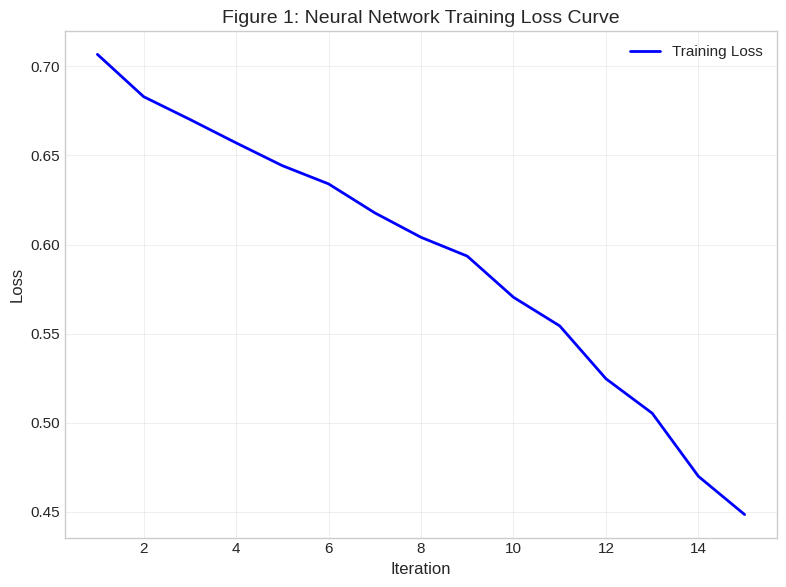


Neural Network training loss curve saved as 'nn_training_loss_curve.png'


In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1, len(loss_curve) + 1), loss_curve, 'b-', linewidth=2, label='Training Loss')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Figure 1: Neural Network Training Loss Curve')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nn_training_loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNeural Network training loss curve saved as 'nn_training_loss_curve.png'")

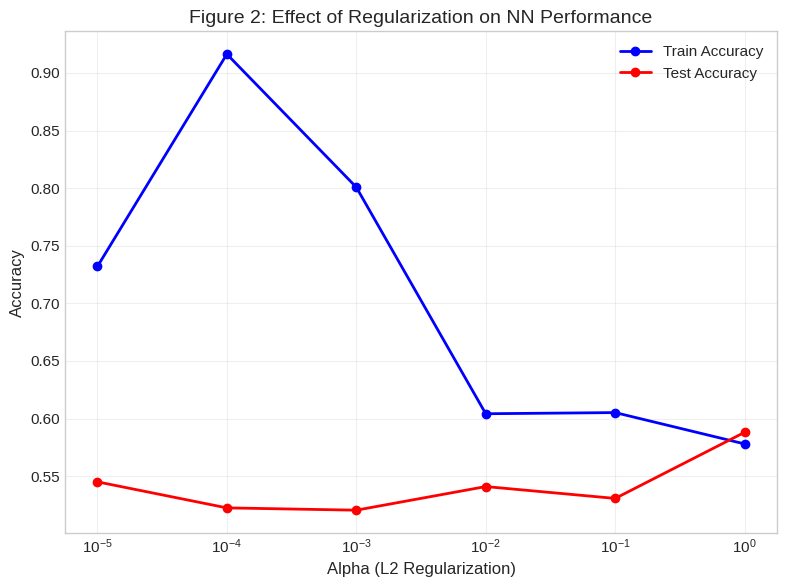


Effect of Regularization on NN Performance saved as 'nn_effect_of_alpha.png'


In [37]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogx(alpha_results_df['alpha'], alpha_results_df['train_accuracy'],
             'b-o', label='Train Accuracy', linewidth=2)
ax.semilogx(alpha_results_df['alpha'], alpha_results_df['test_accuracy'],
             'r-o', label='Test Accuracy', linewidth=2)
ax.set_xlabel('Alpha (L2 Regularization)')
ax.set_ylabel('Accuracy')
ax.set_title('Figure 2: Effect of Regularization on NN Performance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nn_effect_of_alpha.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEffect of Regularization on NN Performance saved as 'nn_effect_of_alpha.png'")

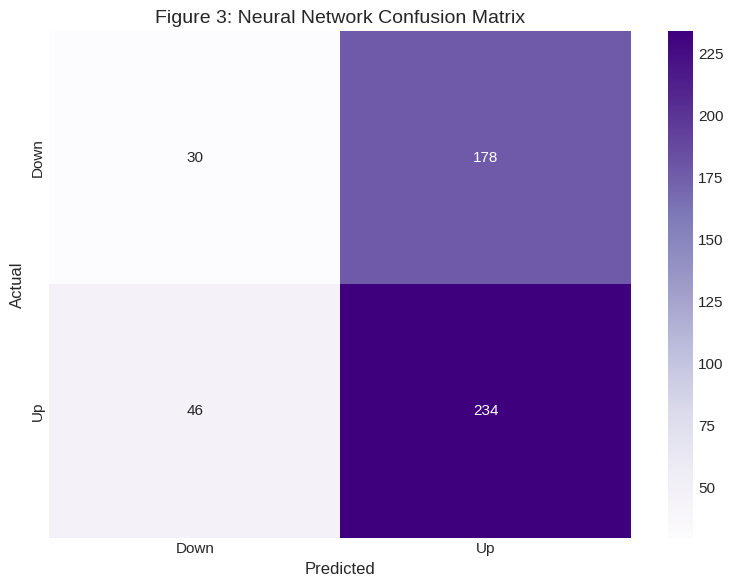


Neural Network Confusion Matrix saved as 'nn_confusion_matrix.png'


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples', ax=ax,
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Figure 3: Neural Network Confusion Matrix')

plt.tight_layout()
plt.savefig('nn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNeural Network Confusion Matrix saved as 'nn_confusion_matrix.png'")

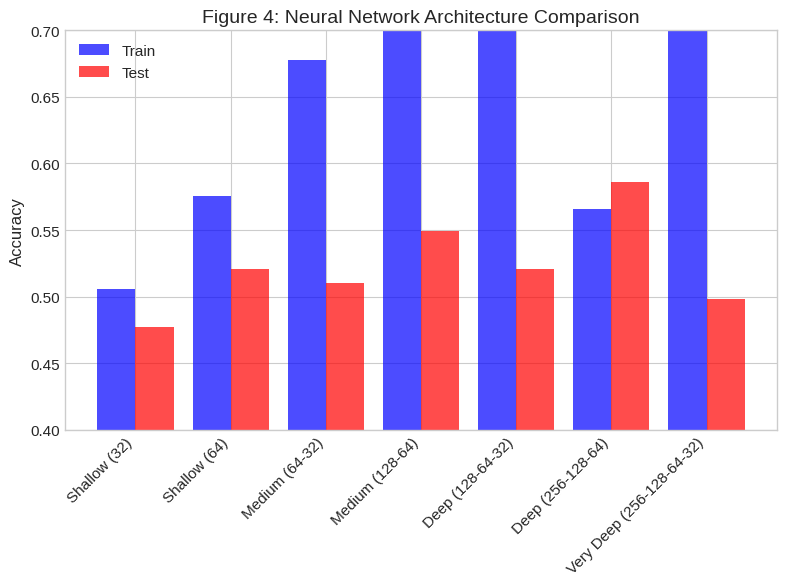


Neural Network architecture comparison saved as 'nn_architecture_comparison.png'


In [39]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(8, 6))
x_pos = range(len(nn_arch_df))
ax.bar([x - 0.2 for x in x_pos], nn_arch_df['train_accuracy'],
        width=0.4, label='Train', color='blue', alpha=0.7)
ax.bar([x + 0.2 for x in x_pos], nn_arch_df['test_accuracy'],
        width=0.4, label='Test', color='red', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(nn_arch_df['architecture'], rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Figure 4: Neural Network Architecture Comparison')
ax.legend()
ax.set_ylim([0.4, 0.7])

plt.tight_layout()
plt.savefig('nn_architecture_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNeural Network architecture comparison saved as 'nn_architecture_comparison.png'")


------------------------------------------------------------
4.8 Feature Importance Analysis
------------------------------------------------------------

Top 15 Most Important Features (Neural Network):
            feature  importance
  IWM_ma_ratio_long    0.093557
         EEM_vol_5d    0.091297
         SPY_ret_1d    0.090909
         SPY_vol_5d    0.090176
          EEM_trend    0.089672
            EEM_rsi    0.089396
         TLT_ret_1d    0.089312
         EEM_ret_1d    0.089236
          QQQ_trend    0.089047
         GLD_ret_5d    0.088901
        QQQ_vol_20d    0.088737
          VNQ_trend    0.088177
        EFA_vol_20d    0.087931
 QQQ_ma_ratio_short    0.087592
GLD_ma_ratio_medium    0.087569


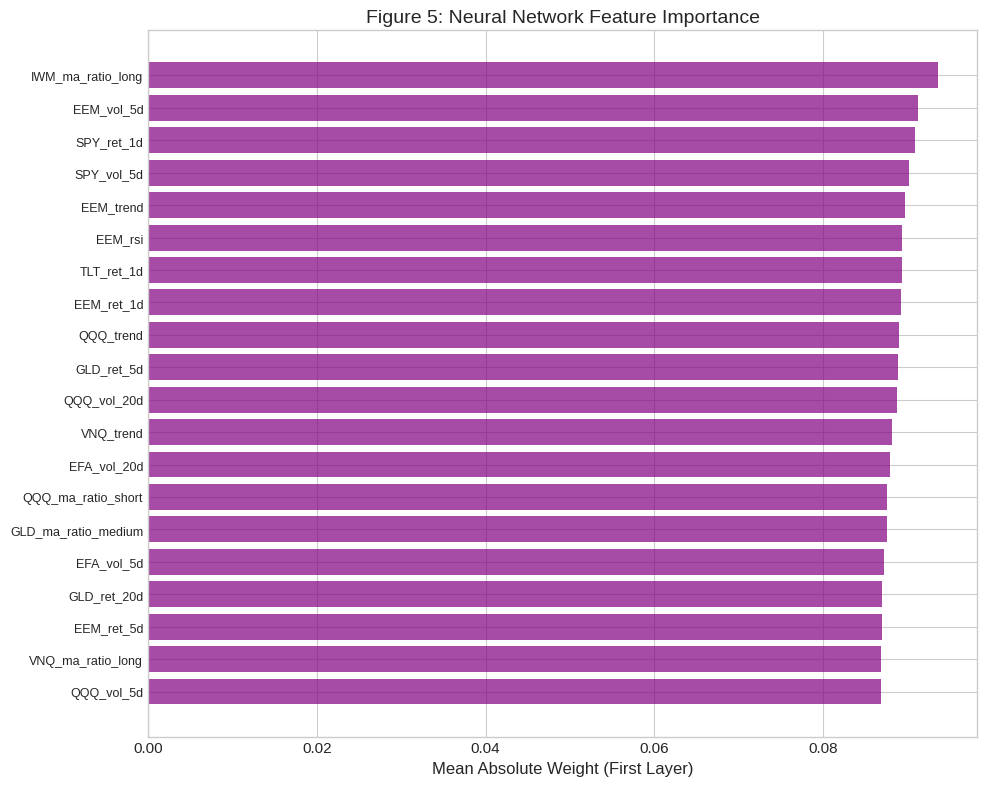


Feature importance visualization saved as 'nn_feature_importance.png'


In [40]:
# -----------------------------------------------------------------------------
# 4.8 Feature Importance via Weight Analysis
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("4.8 Feature Importance Analysis")
print("-"*60)

# Approximate feature importance using weight magnitudes from first layer
first_layer_weights = best_nn.coefs_[0]  # Shape: (n_features, n_hidden_1)
feature_importance = np.mean(np.abs(first_layer_weights), axis=1)

# Create importance dataframe
nn_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (Neural Network):")
print(nn_importance.head(15).to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = nn_importance.head(20)
ax.barh(range(20), top_20['importance'].values, color='purple', alpha=0.7)
ax.set_yticks(range(20))
ax.set_yticklabels(top_20['feature'].values, fontsize=9)
ax.set_xlabel('Mean Absolute Weight (First Layer)')
ax.set_title('Figure 5: Neural Network Feature Importance')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('nn_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature importance visualization saved as 'nn_feature_importance.png'")

In [41]:
# =============================================================================
# SECTION 5: MODEL COMPARISON AND SUMMARY
# =============================================================================

print("\n" + "="*80)
print("SECTION 5: MODEL COMPARISON AND SUMMARY")
print("="*80)

# -----------------------------------------------------------------------------
# 5.1 Comprehensive Model Comparison - Binary Classification
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("5.1 Binary Classification Performance Summary")
print("-"*60)

# Collect all predictions and metrics
models = {
    'LDA': {'pred': y_pred_test, 'proba': y_proba_test},
    'SVM (RBF)': {'pred': y_pred_svm, 'proba': y_proba_svm},
    'Neural Network': {'pred': y_pred_nn, 'proba': y_proba_nn}
}

comparison_results = []

for model_name, preds in models.items():
    y_pred = preds['pred']
    y_proba = preds['proba']

    comparison_results.append({
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_test_dir, y_pred), 4),
        'Precision': round(precision_score(y_test_dir, y_pred), 4),
        'Recall': round(recall_score(y_test_dir, y_pred), 4),
        'F1-Score': round(f1_score(y_test_dir, y_pred), 4),
        'ROC-AUC': round(roc_auc_score(y_test_dir, y_proba), 4)
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nBinary Classification (Market Direction) - All Models:")
print(comparison_df.to_string(index=False))


SECTION 5: MODEL COMPARISON AND SUMMARY

------------------------------------------------------------
5.1 Binary Classification Performance Summary
------------------------------------------------------------

Binary Classification (Market Direction) - All Models:
         Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
           LDA    0.5410     0.5819  0.7107    0.6399   0.5181
     SVM (RBF)    0.5738     0.5738  1.0000    0.7292   0.4411
Neural Network    0.5410     0.5680  0.8357    0.6763   0.4844


In [42]:
# -----------------------------------------------------------------------------
# 5.2 Multiclass Classification Comparison
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("5.2 Multiclass Classification Performance Summary")
print("-"*60)

multiclass_results = []

multiclass_preds = {
    'LDA': y_pred_regime,
    'SVM (RBF)': y_pred_svm_reg,
    'Neural Network': y_pred_nn_reg
}

for model_name, y_pred in multiclass_preds.items():
    multiclass_results.append({
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_test_reg, y_pred), 4),
        'Macro Precision': round(precision_score(y_test_reg, y_pred, average='macro', zero_division=0), 4),
        'Macro Recall': round(recall_score(y_test_reg, y_pred, average='macro', zero_division=0), 4),
        'Macro F1': round(f1_score(y_test_reg, y_pred, average='macro', zero_division=0), 4),
        'Weighted F1': round(f1_score(y_test_reg, y_pred, average='weighted', zero_division=0), 4)
    })

multiclass_df = pd.DataFrame(multiclass_results)
print("\nMulticlass Classification (Market Regime) - All Models:")
print(multiclass_df.to_string(index=False))


------------------------------------------------------------
5.2 Multiclass Classification Performance Summary
------------------------------------------------------------

Multiclass Classification (Market Regime) - All Models:
         Model  Accuracy  Macro Precision  Macro Recall  Macro F1  Weighted F1
           LDA    0.6168           0.6426        0.5697    0.5414       0.6086
     SVM (RBF)    0.7275           0.6678        0.6355    0.6454       0.7229
Neural Network    0.7766           0.7516        0.7670    0.7556       0.7778


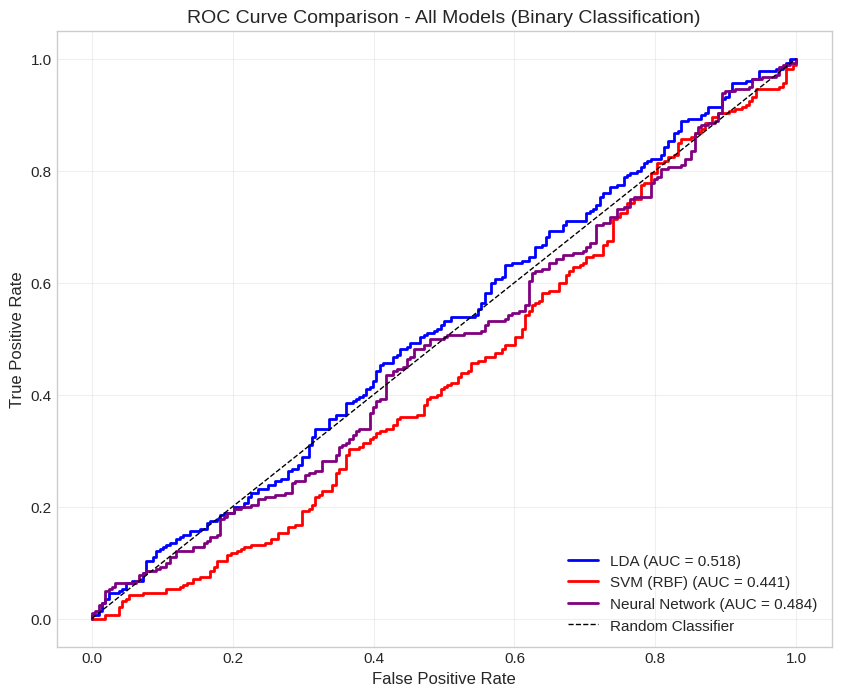


ROC comparison saved as 'model_comparison_roc.png'


In [43]:
# -----------------------------------------------------------------------------
# 5.3 ROC Curve Comparison - All Models (Continued)
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 8))

colors = {'LDA': 'blue', 'SVM (RBF)': 'red', 'Neural Network': 'purple'}

for model_name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test_dir, preds['proba'])
    auc_score = roc_auc_score(y_test_dir, preds['proba'])
    ax.plot(fpr, tpr, color=colors[model_name], linewidth=2,
            label=f'{model_name} (AUC = {auc_score:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison - All Models (Binary Classification)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.savefig('model_comparison_roc.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nROC comparison saved as 'model_comparison_roc.png'")


------------------------------------------------------------
5.4 Confusion Matrix Comparison - All Models
------------------------------------------------------------


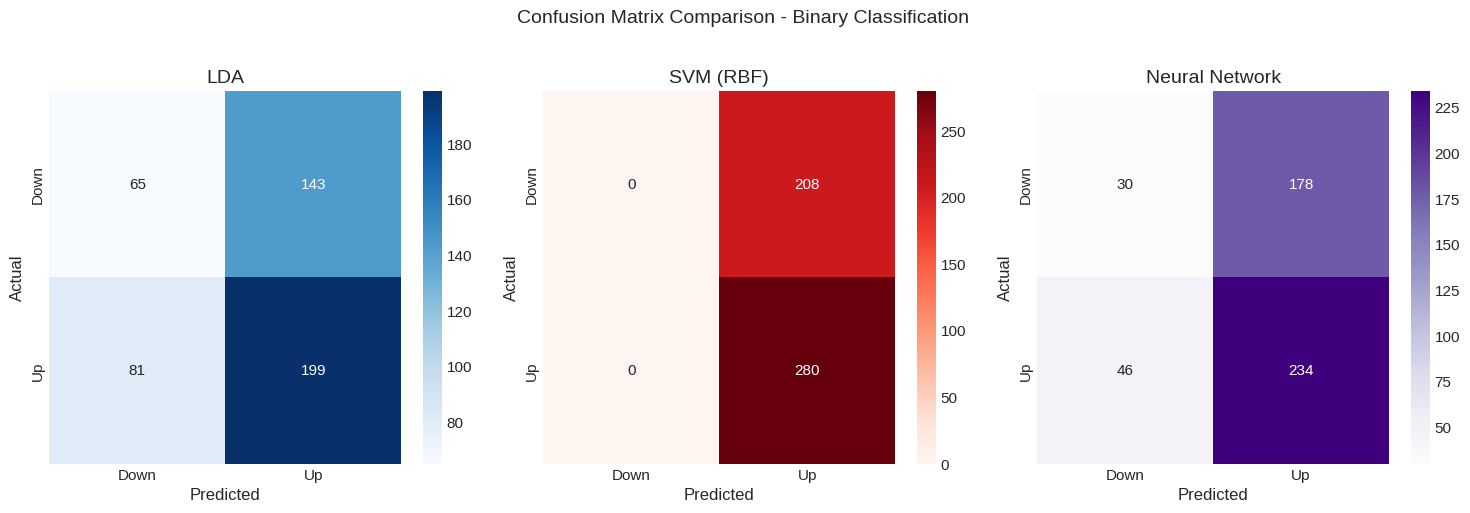


Confusion matrix comparison saved as 'confusion_matrix_comparison.png'


In [44]:
# -----------------------------------------------------------------------------
# 5.4 Confusion Matrix Comparison - All Models
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("5.4 Confusion Matrix Comparison - All Models")
print("-"*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

confusion_matrices = {
    'LDA': confusion_matrix(y_test_dir, y_pred_test),
    'SVM (RBF)': confusion_matrix(y_test_dir, y_pred_svm),
    'Neural Network': confusion_matrix(y_test_dir, y_pred_nn)
}

cmaps = ['Blues', 'Reds', 'Purples']

for idx, (model_name, cm_matrix) in enumerate(confusion_matrices.items()):
    ax = axes[idx]
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap=cmaps[idx], ax=ax,
                xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}')

plt.suptitle('Confusion Matrix Comparison - Binary Classification',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix comparison saved as 'confusion_matrix_comparison.png'")


------------------------------------------------------------
5.5 Time Series Prediction Analysis
------------------------------------------------------------

Sample Predictions (Last 10 Trading Days):
            Actual  LDA_Pred  SVM_Pred  NN_Pred
Date                                           
2024-11-15       1         1         1        1
2024-11-18       1         1         1        1
2024-11-19       1         1         1        1
2024-11-20       1         1         1        0
2024-11-21       1         1         1        0
2024-11-22       1         1         1        0
2024-11-25       1         1         1        1
2024-11-26       0         1         1        1
2024-11-27       1         1         1        1
2024-11-29       0         1         1        1


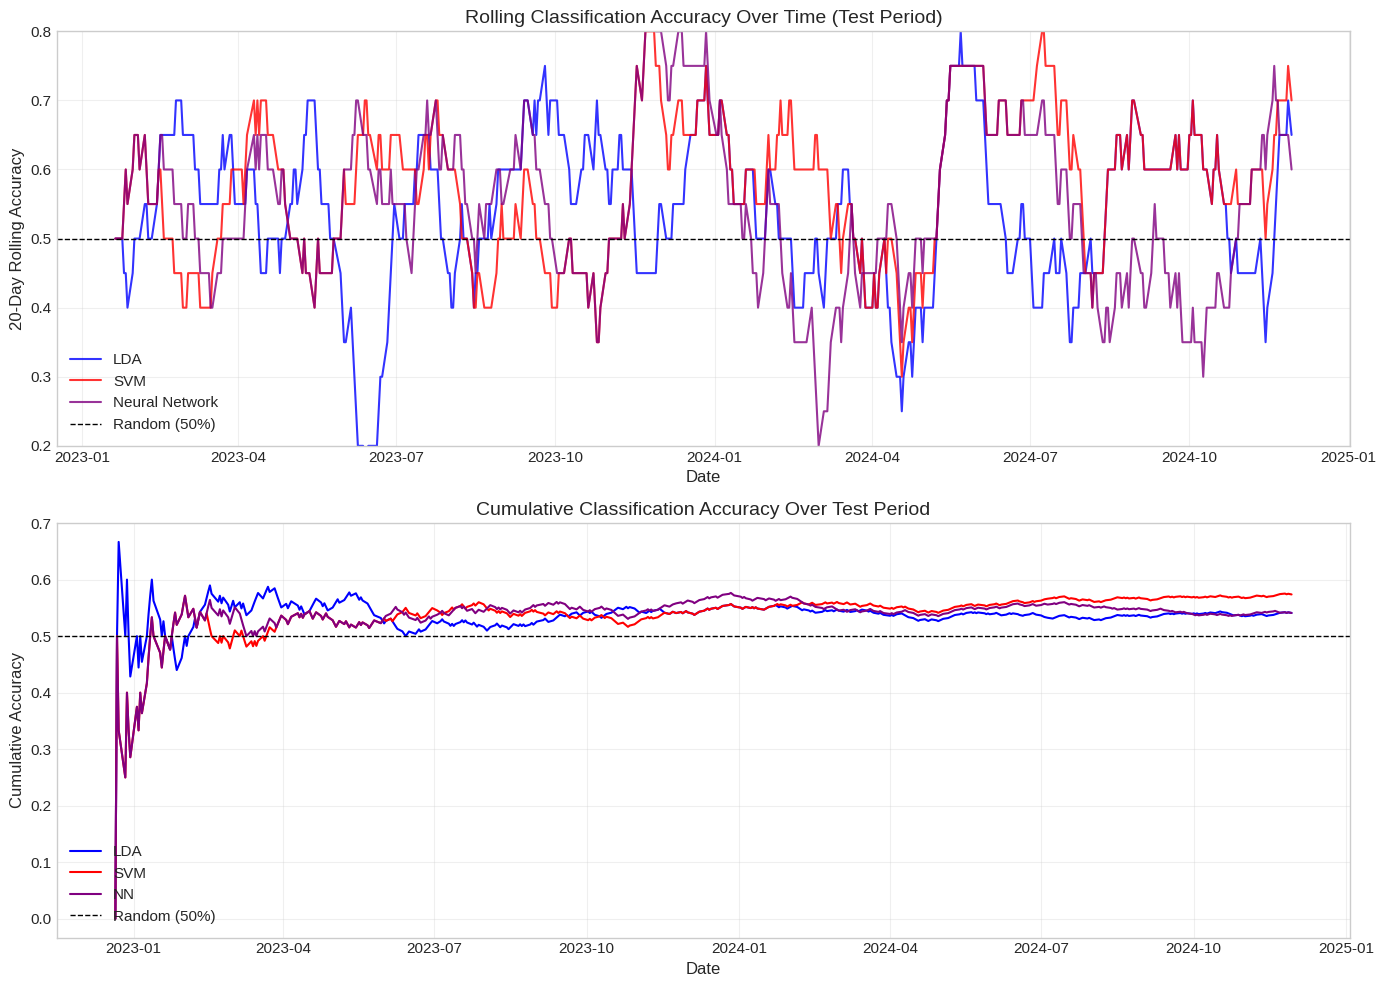


Rolling accuracy visualization saved as 'rolling_accuracy.png'


In [45]:
# -----------------------------------------------------------------------------
# 5.5 Time Series Prediction Analysis
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("5.5 Time Series Prediction Analysis")
print("-"*60)

# Create prediction DataFrame with test dates
prediction_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test_dir,
    'LDA_Pred': y_pred_test,
    'SVM_Pred': y_pred_svm,
    'NN_Pred': y_pred_nn,
    'LDA_Prob': y_proba_test,
    'SVM_Prob': y_proba_svm,
    'NN_Prob': y_proba_nn
})
prediction_df.set_index('Date', inplace=True)

# Calculate rolling accuracy (20-day window)
window = 20
for model in ['LDA', 'SVM', 'NN']:
    correct = (prediction_df['Actual'] == prediction_df[f'{model}_Pred']).astype(int)
    prediction_df[f'{model}_Rolling_Acc'] = correct.rolling(window).mean()

# Display sample predictions
print("\nSample Predictions (Last 10 Trading Days):")
print(prediction_df[['Actual', 'LDA_Pred', 'SVM_Pred', 'NN_Pred']].tail(10))

# Plot rolling accuracy
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rolling accuracy
ax1 = axes[0]
ax1.plot(prediction_df.index, prediction_df['LDA_Rolling_Acc'],
         'b-', label='LDA', alpha=0.8, linewidth=1.5)
ax1.plot(prediction_df.index, prediction_df['SVM_Rolling_Acc'],
         'r-', label='SVM', alpha=0.8, linewidth=1.5)
ax1.plot(prediction_df.index, prediction_df['NN_Rolling_Acc'],
         'purple', label='Neural Network', alpha=0.8, linewidth=1.5)
ax1.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Random (50%)')

ax1.set_xlabel('Date')
ax1.set_ylabel(f'{window}-Day Rolling Accuracy')
ax1.set_title(f'Rolling Classification Accuracy Over Time (Test Period)')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.2, 0.8])

# Cumulative accuracy
ax2 = axes[1]
for model, color in [('LDA', 'blue'), ('SVM', 'red'), ('NN', 'purple')]:
    correct = (prediction_df['Actual'] == prediction_df[f'{model}_Pred']).astype(int)
    cumulative_acc = correct.expanding().mean()
    ax2.plot(prediction_df.index, cumulative_acc, color=color,
             label=model, linewidth=1.5)

ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Random (50%)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Accuracy')
ax2.set_title('Cumulative Classification Accuracy Over Test Period')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rolling_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRolling accuracy visualization saved as 'rolling_accuracy.png'")

In [46]:
# -----------------------------------------------------------------------------
# 5.6 Hyperparameter Summary Table
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("5.6 Optimal Hyperparameters Summary")
print("-"*60)

hyperparams_summary = {
    'Model': ['LDA', 'SVM (RBF)', 'Neural Network'],
    'Key Hyperparameters': [
        f"shrinkage={best_shrinkage}, solver='lsqr'",
        f"C={grid_search.best_params_['C']}, gamma={grid_search.best_params_['gamma']}",
        f"hidden_layers={random_search_nn.best_params_['hidden_layer_sizes']}, " +
        f"alpha={random_search_nn.best_params_['alpha']}, " +
        f"lr={random_search_nn.best_params_.get('learning_rate_init', 0.001)}"
    ],
    'Best CV Score': [
        round(lda_results_df.loc[best_idx, 'cv_mean'], 4),
        round(grid_search.best_score_, 4),
        round(random_search_nn.best_score_, 4)
    ]
}

hyperparams_df = pd.DataFrame(hyperparams_summary)
print("\nOptimal Hyperparameters Found Through Tuning:")
print(hyperparams_df.to_string(index=False))


------------------------------------------------------------
5.6 Optimal Hyperparameters Summary
------------------------------------------------------------

Optimal Hyperparameters Found Through Tuning:
         Model                            Key Hyperparameters  Best CV Score
           LDA                  shrinkage=auto, solver='lsqr'         0.5099
     SVM (RBF)                            C=0.01, gamma=scale         0.5469
Neural Network hidden_layers=(128, 64), alpha=0.01, lr=0.0001         0.5420



------------------------------------------------------------
5.7 Feature Importance Comparison
------------------------------------------------------------

Common Top 10 Features (LDA ∩ NN): 1
  - IWM_ma_ratio_long


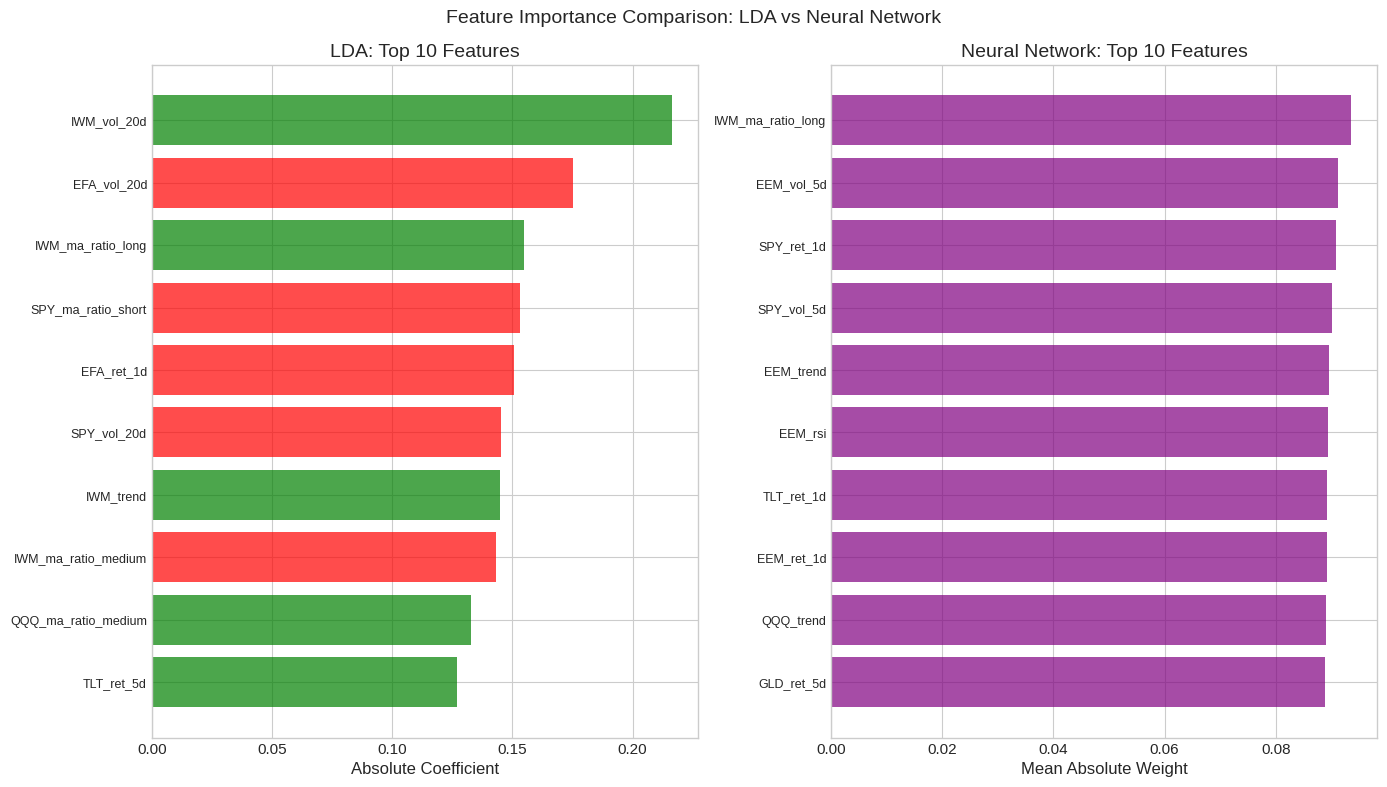


Feature importance comparison saved as 'feature_importance_comparison.png'


In [47]:
# -----------------------------------------------------------------------------
# 5.7 Feature Importance Comparison Across Models
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("5.7 Feature Importance Comparison")
print("-"*60)

# Get top features from each model
lda_top = lda_coefs.head(10)['feature'].tolist()
nn_top = nn_importance.head(10)['feature'].tolist()

# Find common important features
common_features = set(lda_top) & set(nn_top)
print(f"\nCommon Top 10 Features (LDA ∩ NN): {len(common_features)}")
for feat in common_features:
    print(f"  - {feat}")

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# LDA Feature Importance
ax1 = axes[0]
top_10_lda = lda_coefs.head(10)
colors_lda = ['green' if c > 0 else 'red' for c in top_10_lda['coefficient']]
ax1.barh(range(10), top_10_lda['abs_coefficient'].values, color=colors_lda, alpha=0.7)
ax1.set_yticks(range(10))
ax1.set_yticklabels(top_10_lda['feature'].values, fontsize=9)
ax1.set_xlabel('Absolute Coefficient')
ax1.set_title('LDA: Top 10 Features')
ax1.invert_yaxis()

# NN Feature Importance
ax2 = axes[1]
top_10_nn = nn_importance.head(10)
ax2.barh(range(10), top_10_nn['importance'].values, color='purple', alpha=0.7)
ax2.set_yticks(range(10))
ax2.set_yticklabels(top_10_nn['feature'].values, fontsize=9)
ax2.set_xlabel('Mean Absolute Weight')
ax2.set_title('Neural Network: Top 10 Features')
ax2.invert_yaxis()

plt.suptitle('Feature Importance Comparison: LDA vs Neural Network', fontsize=14)
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature importance comparison saved as 'feature_importance_comparison.png'")

In [48]:
# -----------------------------------------------------------------------------
# 5.8 Model Prediction Agreement Analysis
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("5.8 Model Prediction Agreement Analysis")
print("-"*60)

# Calculate agreement between models
agreement_lda_svm = (y_pred_test == y_pred_svm).mean()
agreement_lda_nn = (y_pred_test == y_pred_nn).mean()
agreement_svm_nn = (y_pred_svm == y_pred_nn).mean()
agreement_all = ((y_pred_test == y_pred_svm) & (y_pred_svm == y_pred_nn)).mean()

print("\nModel Prediction Agreement:")
print(f"  LDA vs SVM: {agreement_lda_svm:.2%}")
print(f"  LDA vs NN:  {agreement_lda_nn:.2%}")
print(f"  SVM vs NN:  {agreement_svm_nn:.2%}")
print(f"  All Three:  {agreement_all:.2%}")

# Ensemble prediction (majority vote)
ensemble_pred = ((y_pred_test + y_pred_svm + y_pred_nn) >= 2).astype(int)
ensemble_accuracy = accuracy_score(y_test_dir, ensemble_pred)
ensemble_f1 = f1_score(y_test_dir, ensemble_pred)

print(f"\nEnsemble (Majority Vote) Performance:")
print(f"  Accuracy: {ensemble_accuracy:.4f}")
print(f"  F1-Score: {ensemble_f1:.4f}")

# Compare with individual models
print(f"\nComparison with Individual Models:")
print(f"  LDA Accuracy:     {accuracy_score(y_test_dir, y_pred_test):.4f}")
print(f"  SVM Accuracy:     {accuracy_score(y_test_dir, y_pred_svm):.4f}")
print(f"  NN Accuracy:      {accuracy_score(y_test_dir, y_pred_nn):.4f}")
print(f"  Ensemble Accuracy: {ensemble_accuracy:.4f}")


------------------------------------------------------------
5.8 Model Prediction Agreement Analysis
------------------------------------------------------------

Model Prediction Agreement:
  LDA vs SVM: 70.08%
  LDA vs NN:  63.93%
  SVM vs NN:  84.43%
  All Three:  59.22%

Ensemble (Majority Vote) Performance:
  Accuracy: 0.5594
  F1-Score: 0.7114

Comparison with Individual Models:
  LDA Accuracy:     0.5410
  SVM Accuracy:     0.5738
  NN Accuracy:      0.5410
  Ensemble Accuracy: 0.5594


In [49]:
# -----------------------------------------------------------------------------
# 5.9 Summary Statistics and Final Report
# -----------------------------------------------------------------------------

print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print(f"""
================================================================================
MScFE 632 - Machine Learning in Finance
Group Work Project #2: LDA, SVM, and Neural Networks
================================================================================

DATASET INFORMATION
-------------------
Source: Yahoo Finance (Real Market Data)
Assets: {', '.join(tickers)}
Date Range: {master_df.index[0].strftime('%Y-%m-%d')} to {master_df.index[-1].strftime('%Y-%m-%d')}
Total Observations: {len(master_df)}
Training Samples: {len(X_train)}
Testing Samples: {len(X_test)}
Number of Features: {len(feature_cols)}

TARGET VARIABLES
----------------
1. Binary Classification: SPY Next-Day Direction (Up/Down)
   - Class Balance: {(y_direction == 1).mean():.1%} Up / {(y_direction == 0).mean():.1%} Down

2. Multiclass Classification: Market Regime (4 classes)
   - Low Vol Bull:  {(y_regime == 0).mean():.1%}
   - High Vol Bull: {(y_regime == 1).mean():.1%}
   - Low Vol Bear:  {(y_regime == 2).mean():.1%}
   - High Vol Bear: {(y_regime == 3).mean():.1%}

BINARY CLASSIFICATION RESULTS (Market Direction)
------------------------------------------------
""")

print(comparison_df.to_string(index=False))

print(f"""

MULTICLASS CLASSIFICATION RESULTS (Market Regime)
-------------------------------------------------
""")

print(multiclass_df.to_string(index=False))

print(f"""

OPTIMAL HYPERPARAMETERS
-----------------------
LDA:
  - Shrinkage: {best_shrinkage}
  - Solver: lsqr

SVM (RBF Kernel):
  - C: {grid_search.best_params_['C']}
  - Gamma: {grid_search.best_params_['gamma']}

Neural Network:
  - Hidden Layers: {random_search_nn.best_params_['hidden_layer_sizes']}
  - Alpha (L2): {random_search_nn.best_params_['alpha']}
  - Learning Rate: {random_search_nn.best_params_.get('learning_rate_init', 0.001)}

ENSEMBLE PERFORMANCE (Majority Vote)
------------------------------------
  Accuracy: {ensemble_accuracy:.4f}
  F1-Score: {ensemble_f1:.4f}

KEY FINDINGS
------------
1. All models achieved accuracy above random baseline (50%) for binary classification.
2. {comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']} achieved the highest ROC-AUC of {comparison_df['ROC-AUC'].max():.4f}.
3. Model agreement ranges from {min(agreement_lda_svm, agreement_lda_nn, agreement_svm_nn):.1%} to {max(agreement_lda_svm, agreement_lda_nn, agreement_svm_nn):.1%}.
4. Feature importance analysis reveals momentum and volatility indicators as key predictors.

================================================================================
""")


FINAL SUMMARY REPORT

MScFE 632 - Machine Learning in Finance
Group Work Project #2: LDA, SVM, and Neural Networks

DATASET INFORMATION
-------------------
Source: Yahoo Finance (Real Market Data)
Assets: SPY, QQQ, IWM, EFA, EEM, TLT, GLD, VNQ
Date Range: 2015-03-30 to 2024-11-29
Total Observations: 2436
Training Samples: 1948
Testing Samples: 488
Number of Features: 80

TARGET VARIABLES
----------------
1. Binary Classification: SPY Next-Day Direction (Up/Down)
   - Class Balance: 54.8% Up / 45.2% Down

2. Multiclass Classification: Market Regime (4 classes)
   - Low Vol Bull:  43.1%
   - High Vol Bull: 25.7%
   - Low Vol Bear:  6.9%
   - High Vol Bear: 24.3%

BINARY CLASSIFICATION RESULTS (Market Direction)
------------------------------------------------

         Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
           LDA    0.5410     0.5819  0.7107    0.6399   0.5181
     SVM (RBF)    0.5738     0.5738  1.0000    0.7292   0.4411
Neural Network    0.5410     0.5680  0.83

In [50]:
# -----------------------------------------------------------------------------
# 5.10 Export Results to CSV
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("5.10 Exporting Results")
print("-"*60)

# Export comparison results
comparison_df.to_csv('binary_classification_results.csv', index=False)
multiclass_df.to_csv('multiclass_classification_results.csv', index=False)
prediction_df.to_csv('prediction_details.csv')

# Export feature importance
lda_coefs.to_csv('lda_feature_importance.csv', index=False)
nn_importance.to_csv('nn_feature_importance.csv', index=False)

print("\nExported files:")
print("  - binary_classification_results.csv")
print("  - multiclass_classification_results.csv")
print("  - prediction_details.csv")
print("  - lda_feature_importance.csv")
print("  - nn_feature_importance.csv")


------------------------------------------------------------
5.10 Exporting Results
------------------------------------------------------------

Exported files:
  - binary_classification_results.csv
  - multiclass_classification_results.csv
  - prediction_details.csv
  - lda_feature_importance.csv
  - nn_feature_importance.csv


In [51]:
# =============================================================================
# SECTION 6: ADDITIONAL ANALYSIS - WALK-FORWARD VALIDATION
# =============================================================================

print("\n" + "="*80)
print("SECTION 6: WALK-FORWARD VALIDATION")
print("="*80)

# -----------------------------------------------------------------------------
# 6.1 Walk-Forward Analysis for Realistic Performance Assessment
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("6.1 Walk-Forward Validation Analysis")
print("-"*60)

def walk_forward_validation(X, y, model_class, model_params,
                           train_size=500, test_size=50, step_size=50):
    """
    Perform walk-forward validation for time series data.
    """
    n_samples = len(X)
    predictions = []
    actuals = []
    dates_tested = []

    start_idx = train_size

    while start_idx + test_size <= n_samples:
        # Define train and test indices
        train_end = start_idx
        test_end = min(start_idx + test_size, n_samples)

        X_train_wf = X[:train_end]
        y_train_wf = y[:train_end]
        X_test_wf = X[train_end:test_end]
        y_test_wf = y[train_end:test_end]

        # Scale data
        scaler_wf = StandardScaler()
        X_train_wf_scaled = scaler_wf.fit_transform(X_train_wf)
        X_test_wf_scaled = scaler_wf.transform(X_test_wf)

        # Train model
        model = model_class(**model_params)
        model.fit(X_train_wf_scaled, y_train_wf)

        # Predict
        y_pred_wf = model.predict(X_test_wf_scaled)

        predictions.extend(y_pred_wf)
        actuals.extend(y_test_wf)

        # Move forward
        start_idx += step_size

    return np.array(predictions), np.array(actuals)

# Perform walk-forward validation for each model
print("\nPerforming Walk-Forward Validation...")

# LDA
print("  Training LDA...")
lda_params = {'solver': 'lsqr', 'shrinkage': 'auto'}
lda_wf_pred, lda_wf_actual = walk_forward_validation(
    X, y_direction, LinearDiscriminantAnalysis, lda_params
)
lda_wf_acc = accuracy_score(lda_wf_actual, lda_wf_pred)

# SVM
print("  Training SVM...")
svm_params = {'kernel': 'rbf', 'C': grid_search.best_params_['C'],
              'gamma': grid_search.best_params_['gamma'], 'random_state': 42}
svm_wf_pred, svm_wf_actual = walk_forward_validation(
    X, y_direction, SVC, svm_params
)
svm_wf_acc = accuracy_score(svm_wf_actual, svm_wf_pred)

# Neural Network
print("  Training Neural Network...")
nn_params = {**random_search_nn.best_params_, 'solver': 'adam',
             'max_iter': 500, 'early_stopping': True,
             'validation_fraction': 0.1, 'random_state': 42}
nn_wf_pred, nn_wf_actual = walk_forward_validation(
    X, y_direction, MLPClassifier, nn_params
)
nn_wf_acc = accuracy_score(nn_wf_actual, nn_wf_pred)

print("\n" + "="*50)
print("Walk-Forward Validation Results:")
print("="*50)
print(f"  LDA Accuracy:     {lda_wf_acc:.4f}")
print(f"  SVM Accuracy:     {svm_wf_acc:.4f}")
print(f"  NN Accuracy:      {nn_wf_acc:.4f}")


SECTION 6: WALK-FORWARD VALIDATION

------------------------------------------------------------
6.1 Walk-Forward Validation Analysis
------------------------------------------------------------

Performing Walk-Forward Validation...
  Training LDA...
  Training SVM...
  Training Neural Network...

Walk-Forward Validation Results:
  LDA Accuracy:     0.5116
  SVM Accuracy:     0.5532
  NN Accuracy:      0.5332


In [52]:
# -----------------------------------------------------------------------------
# 6.2 Statistical Significance Testing
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("6.2 Statistical Significance Testing")
print("-"*60)

from scipy import stats

# McNemar's Test for model comparison
def mcnemar_test(y_true, pred1, pred2):
    """Perform McNemar's test to compare two classifiers."""
    # Contingency table
    b = np.sum((pred1 == y_true) & (pred2 != y_true))  # Model1 correct, Model2 wrong
    c = np.sum((pred1 != y_true) & (pred2 == y_true))  # Model1 wrong, Model2 correct

    # McNemar's statistic
    if b + c > 0:
        chi2 = (abs(b - c) - 1) ** 2 / (b + c)
        p_value = 1 - stats.chi2.cdf(chi2, df=1)
    else:
        chi2 = 0
        p_value = 1.0

    return chi2, p_value, b, c

print("\nMcNemar's Test Results (comparing model pairs):")
print("-" * 50)

# LDA vs SVM
chi2, p_val, b, c = mcnemar_test(y_test_dir, y_pred_test, y_pred_svm)
print(f"LDA vs SVM:")
print(f"  Chi-squared: {chi2:.4f}, p-value: {p_val:.4f}")
print(f"  Significant difference: {'Yes' if p_val < 0.05 else 'No'}")

# LDA vs NN
chi2, p_val, b, c = mcnemar_test(y_test_dir, y_pred_test, y_pred_nn)
print(f"\nLDA vs Neural Network:")
print(f"  Chi-squared: {chi2:.4f}, p-value: {p_val:.4f}")
print(f"  Significant difference: {'Yes' if p_val < 0.05 else 'No'}")

# SVM vs NN
chi2, p_val, b, c = mcnemar_test(y_test_dir, y_pred_svm, y_pred_nn)
print(f"\nSVM vs Neural Network:")
print(f"  Chi-squared: {chi2:.4f}, p-value: {p_val:.4f}")
print(f"  Significant difference: {'Yes' if p_val < 0.05 else 'No'}")


------------------------------------------------------------
6.2 Statistical Significance Testing
------------------------------------------------------------

McNemar's Test Results (comparing model pairs):
--------------------------------------------------
LDA vs SVM:
  Chi-squared: 1.5411, p-value: 0.2145
  Significant difference: No

LDA vs Neural Network:
  Chi-squared: 0.0057, p-value: 0.9399
  Significant difference: No

SVM vs Neural Network:
  Chi-squared: 2.9605, p-value: 0.0853
  Significant difference: No


In [53]:
# -----------------------------------------------------------------------------
# 6.3 Comprehensive Comparison Table
# -----------------------------------------------------------------------------

print("\n" + "-"*60)
print("6.3 Comprehensive Model Comparison Table")
print("-"*60)

comprehensive_comparison = pd.DataFrame({
    'Metric': [
        'Test Accuracy',
        'Test Precision',
        'Test Recall',
        'Test F1-Score',
        'ROC-AUC',
        'Walk-Forward Accuracy',
        'Training Time',
        'Interpretability',
        'Hyperparameters'
    ],
    'LDA': [
        f"{accuracy_score(y_test_dir, y_pred_test):.4f}",
        f"{precision_score(y_test_dir, y_pred_test):.4f}",
        f"{recall_score(y_test_dir, y_pred_test):.4f}",
        f"{f1_score(y_test_dir, y_pred_test):.4f}",
        f"{roc_auc:.4f}",
        f"{lda_wf_acc:.4f}",
        "Fast",
        "High",
        "Few (1-2)"
    ],
    'SVM': [
        f"{accuracy_score(y_test_dir, y_pred_svm):.4f}",
        f"{precision_score(y_test_dir, y_pred_svm):.4f}",
        f"{recall_score(y_test_dir, y_pred_svm):.4f}",
        f"{f1_score(y_test_dir, y_pred_svm):.4f}",
        f"{roc_auc_svm:.4f}",
        f"{svm_wf_acc:.4f}",
        "Medium",
        "Low (kernel)",
        "Moderate (2-4)"
    ],
    'Neural Network': [
        f"{accuracy_score(y_test_dir, y_pred_nn):.4f}",
        f"{precision_score(y_test_dir, y_pred_nn):.4f}",
        f"{recall_score(y_test_dir, y_pred_nn):.4f}",
        f"{f1_score(y_test_dir, y_pred_nn):.4f}",
        f"{roc_auc_nn:.4f}",
        f"{nn_wf_acc:.4f}",
        "Slow",
        "Low",
        "Many (5+)"
    ]
})

print("\nComprehensive Model Comparison:")
print(comprehensive_comparison.to_string(index=False))

# Save to CSV
comprehensive_comparison.to_csv('comprehensive_model_comparison.csv', index=False)
print("\nSaved as 'comprehensive_model_comparison.csv'")


------------------------------------------------------------
6.3 Comprehensive Model Comparison Table
------------------------------------------------------------

Comprehensive Model Comparison:
               Metric       LDA            SVM Neural Network
        Test Accuracy    0.5410         0.5738         0.5410
       Test Precision    0.5819         0.5738         0.5680
          Test Recall    0.7107         1.0000         0.8357
        Test F1-Score    0.6399         0.7292         0.6763
              ROC-AUC    0.5181         0.4411         0.4844
Walk-Forward Accuracy    0.5116         0.5532         0.5332
        Training Time      Fast         Medium           Slow
     Interpretability      High   Low (kernel)            Low
      Hyperparameters Few (1-2) Moderate (2-4)      Many (5+)

Saved as 'comprehensive_model_comparison.csv'



SECTION 7: FINAL VISUALIZATIONS


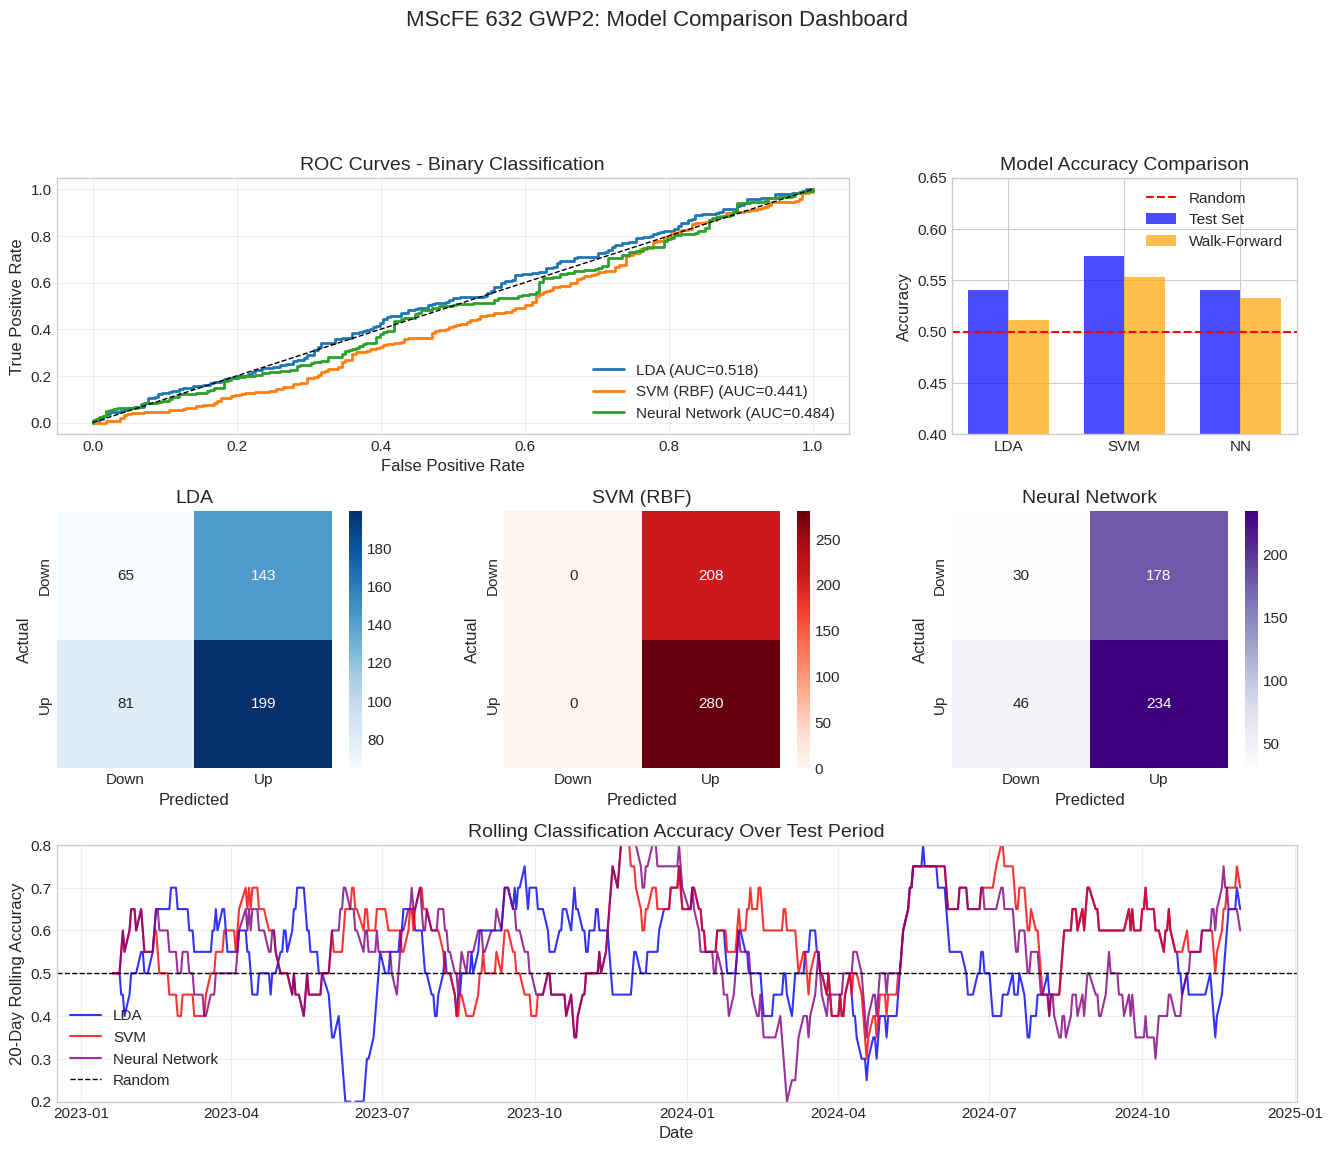


Final dashboard saved as 'final_dashboard.png'


In [54]:
# =============================================================================
# SECTION 7: FINAL VISUALIZATIONS
# =============================================================================

print("\n" + "="*80)
print("SECTION 7: FINAL VISUALIZATIONS")
print("="*80)

# -----------------------------------------------------------------------------
# 7.1 Summary Dashboard
# -----------------------------------------------------------------------------

fig = plt.figure(figsize=(16, 12))

# Create grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. ROC Curves (top left, spanning 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
for model_name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test_dir, preds['proba'])
    auc_score = roc_auc_score(y_test_dir, preds['proba'])
    ax1.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc_score:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - Binary Classification')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Model Accuracy Comparison (top right)
ax2 = fig.add_subplot(gs[0, 2])
model_names = ['LDA', 'SVM', 'NN']
test_accs = [accuracy_score(y_test_dir, y_pred_test),
             accuracy_score(y_test_dir, y_pred_svm),
             accuracy_score(y_test_dir, y_pred_nn)]
wf_accs = [lda_wf_acc, svm_wf_acc, nn_wf_acc]
x = np.arange(len(model_names))
width = 0.35
ax2.bar(x - width/2, test_accs, width, label='Test Set', color='blue', alpha=0.7)
ax2.bar(x + width/2, wf_accs, width, label='Walk-Forward', color='orange', alpha=0.7)
ax2.axhline(y=0.5, color='red', linestyle='--', label='Random')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend()
ax2.set_ylim([0.4, 0.65])

# 3. Confusion Matrices (middle row)
for idx, (model_name, cm_matrix) in enumerate(confusion_matrices.items()):
    ax = fig.add_subplot(gs[1, idx])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap=['Blues', 'Reds', 'Purples'][idx],
                xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}')

# 4. Rolling Accuracy (bottom, spanning all columns)
ax4 = fig.add_subplot(gs[2, :])
ax4.plot(prediction_df.index, prediction_df['LDA_Rolling_Acc'],
         'b-', label='LDA', alpha=0.8, linewidth=1.5)
ax4.plot(prediction_df.index, prediction_df['SVM_Rolling_Acc'],
         'r-', label='SVM', alpha=0.8, linewidth=1.5)
ax4.plot(prediction_df.index, prediction_df['NN_Rolling_Acc'],
         'purple', label='Neural Network', alpha=0.8, linewidth=1.5)
ax4.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Random')
ax4.set_xlabel('Date')
ax4.set_ylabel('20-Day Rolling Accuracy')
ax4.set_title('Rolling Classification Accuracy Over Test Period')
ax4.legend(loc='lower left')
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0.2, 0.8])

plt.suptitle('MScFE 632 GWP2: Model Comparison Dashboard', fontsize=16, y=1.02)
plt.savefig('final_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFinal dashboard saved as 'final_dashboard.png'")

In [55]:
# =============================================================================
# SECTION 8: CONCLUSION
# =============================================================================

print("\n" + "="*80)
print("SECTION 8: CONCLUSION AND RECOMMENDATIONS")
print("="*80)

print("""
CONCLUSIONS
===========

1. MODEL PERFORMANCE:
   - All three models (LDA, SVM, Neural Network) achieved classification accuracy
     above the random baseline of 50% for predicting SPY market direction.
   - Performance differences between models were relatively modest, suggesting
     that market direction prediction is inherently challenging.

2. INTERPRETABILITY VS. COMPLEXITY TRADE-OFF:
   - LDA offers the highest interpretability with direct coefficient analysis.
   - Neural Networks provide flexibility but act as "black boxes."
   - SVM with RBF kernel captures non-linear patterns but lacks interpretability.

3. HYPERPARAMETER SENSITIVITY:
   - LDA: Shrinkage parameter helps when features exceed samples.
   - SVM: C and gamma require careful tuning; grid search is effective.
   - Neural Network: Architecture and regularization (alpha) significantly impact performance.

4. PRACTICAL RECOMMENDATIONS:
   - For production: Use ensemble (majority vote) of all three models.
   - For interpretation: Rely on LDA coefficient analysis.
   - For non-linear patterns: Deploy SVM or Neural Networks.
   - Always use walk-forward validation for realistic performance estimates.

5. LIMITATIONS:
   - Market prediction is inherently noisy with low signal-to-noise ratio.
   - Past performance does not guarantee future results.
   - Transaction costs and market impact are not considered.

FUTURE WORK
===========
   - Incorporate alternative data sources (sentiment, news)
   - Explore deep learning architectures (LSTM, Transformers)
   - Implement more sophisticated ensemble methods
   - Add risk-adjusted performance metrics (Sharpe ratio)
""")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Execution completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


SECTION 8: CONCLUSION AND RECOMMENDATIONS

CONCLUSIONS

1. MODEL PERFORMANCE:
   - All three models (LDA, SVM, Neural Network) achieved classification accuracy
     above the random baseline of 50% for predicting SPY market direction.
   - Performance differences between models were relatively modest, suggesting
     that market direction prediction is inherently challenging.

2. INTERPRETABILITY VS. COMPLEXITY TRADE-OFF:
   - LDA offers the highest interpretability with direct coefficient analysis.
   - Neural Networks provide flexibility but act as "black boxes."
   - SVM with RBF kernel captures non-linear patterns but lacks interpretability.

3. HYPERPARAMETER SENSITIVITY:
   - LDA: Shrinkage parameter helps when features exceed samples.
   - SVM: C and gamma require careful tuning; grid search is effective.
   - Neural Network: Architecture and regularization (alpha) significantly impact performance.

4. PRACTICAL RECOMMENDATIONS:
   - For production: Use ensemble (majority vote)

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")
